# Анализ данных об играх для определения потенциально популярного продукта и планирование рекламной кампании

Для начала откроем файл с данными и изучим их, для этого подключим библиотеку `pandas` помимо него подключим еще остальные библиотеки который нам пригодятся. Для того чтобы прочитать данные из датасета воспользуемся методом `read_csv`, для получения общей информации о датасете воспользуемся методом `info`.

### Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data_games = pd.read_csv('/datasets/games.csv')
except:
    data_games = pd.read_csv('games.csv')
data_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Как видно по данным у нас есть 11 различных столбцов с данными об играх, половина столбцов содержит пропуски в данных, в некоторых совсем минимальное количество, но есть и такие столбцы, где пропущено больше половины данных. Сразу бросается в глаза, что у столбца `Year_of_Release` — год выпуска, можно изменить тип данных на целочисленный, так как год не может быть дробным. У столбца `User_Score` — оценка пользователей указан тип данных **object**, но судя по описанию столбца там должен быть или целочисленный или вещественный тип данных, скорее всего на тип данных в этом столбце повлияли пропуски, либо там могут быть указаны и символьные значения. Тоже нельзя сказать о столбце `Rating` — рейтинг от организации ESRB, так как там по данным в строках видно, что указано символьное значение, в данном столбце нет необходимости менять тип данных.

### Предобработка данных

Преобразуем тип данных в нужные форматы, но перед этим измененим названия столбцов на корректный формат, приведем все к нижнему регистру, после выполнения данных действий, попробуем выяснить причину появления пропусков в данных и по возможности заполнить их.

In [4]:
data_games.columns = data_games.columns.str.lower()

### Начиная с этого момента везде будем указываем название столбцов в нижнем регистре, так как изменили названия столбцов

Преобразуем тип данных в столбце `year_of_release` — год выпуска в целочисленный, так как год не может быть дробным:

In [5]:
data_games['year_of_release'] = data_games['year_of_release'].convert_dtypes()

Тип данных в столбце `user_score` — оценка пользователей, логично преобразовать в вещестенный тип, так в первых строках в этом столбце есть значение **8.3** и это не целое число, однако сначала проверим какие есть уникальные значения в этом столбце, может среди числовых данных и пропусков, есть символьные значения. Посмотрим уникальные значения в столбце `user_score`.

In [6]:
data_games.sort_values(by='user_score')['user_score'].unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Как видно по уникальным значениям в столбце `user_score` есть значение **tbd**, данная аббревиатура расшифровывается в английском как *to be announced* или *to be arranged* и означает соответственно "будет объявлено позднее" или "будет сообщено", вероятно такая оценка указывается для игр по которым ещё мало оценок и нельзя сделать вывод о корректной оценке или же игра еще не вышла и у пользователей нет возможности её оценить. Посмотрим количество игр с такой оценкой:

In [7]:
data_games[data_games['user_score'] == 'tbd']['user_score'].count()

2424

Почти 2.5 тысячи игр с такой оценкой, не получится заменить значение **tbd** на медианное значение оценки например по жанрам игры или по платформе, в таком случай будет выброс на данных, что может повлиять на результаты исследования. Следовательно, значение **tbd** `user_score` логичнее всего заменить на пропуски в данных, так заменить мы его не можем и согласно расшифровке значения можно сделать, что игры у которых оценка **tbd** это ещё не оцененые пользователями игры.

Для замены значения **tbd** на пропуски воспользуемся методом *to_numeric* и для параметра *errors* укажим значение **coerce**, с помощью метода преобразуем тип данных с **object** в вещественный, а из-за того что мы указали значение **coerce** в параметре *errors* значения, которые нельзя будет преобразовать в вещественный тип, принудительно заменятся на пропуски.

In [8]:
data_games['user_score'] = pd.to_numeric(data_games['user_score'], errors='coerce')

Теперь изучим пропуски в столбцах, начнем по порядку со столбца `name` — название игры.

In [9]:
data_games[data_games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


По данным видно, что всего 2 пропуска в столбце `name`, также видно, что есть связанные пропуски в столбце `genre` — жанр игры, пропуски в столбце `genre` выглядит логично — нельзя опредлить жанр игры не зная её название. Логично предположить, что если неизвестно название игры, то и нельзя понять какая у неё оценка и определить по ней рейтинг.

Название платформы **GEN** говорит о том, что эти две игры были выпущены под приставку SEGA, которая была выпущена в Японии, первая игра не продавалась в Японии, а вторая продалась только в Японии, но объем продаж был совсем маленьким. Причина пропусков в столбце `name` может быть связана с тем, что указаные игры 1993 года продались совсем в небольшом количестве, о них осталось мало информации, поэтому не указали их название, однако более правдоподобными выглядят техническая ошибка или человеческий фактор, так как указаны данные о количестве проданных копий в разных странах.

Здесь указаны данные о платформе и годе выпуска игры, однако по продажам видно что это были не очень популярные игры, удалим эти данные из датасета, вряд ли две эти строки сильно влияют на данные и определить какое тут может быть название игры или её жанры мы никак не можем, есть конечно вариант, найти игру по количеству проданных копий, однако такая игра может быть не одна, та и вариаций жанров игры достаточно много.

In [10]:
print('Количество строк и столбцов перед удалением строк:', data_games.shape)
data_games = data_games.dropna(subset=['name'])
print('Количество строк и столбцов после удаления строк:', data_games.shape)

Количество строк и столбцов перед удалением строк: (16715, 11)
Количество строк и столбцов после удаления строк: (16713, 11)


Лишние данные мы не удалили, только две строки, где были пропуски в столбце `name`.

Посмотрим теперь данные где указаны пропуски в столбце `year_of_release` — год выпуска.

In [11]:
data_games[data_games['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


По данным видно, что в названии некоторых игр есть год, однако это не говорит о том, что в этот год была выпущена игра, допустим игры по футболу, в большинстве случаев выпускают на год раньше, чем указано в названии игры, да и не факт что в названии игры число подразумевает именно год выпуска игры. Одной из причин пропусков в данных, как раз могло быть указание года в названии игры, но данная причина подходит не для всех игр, есть названия игр, где не указаны никакие числа, здесь причина пропусков могли быть какие-либо технические ошибки при сборе данных или же для игр у которые имеют небольшое количество проданных копий не стали указывать год выпуска, так как они не такие популярные.

По каким-то косвенным признак определить год выпуска игры вряд ли сможем, так как ни жанр, ни количество проданных копий, ни оценка игры не влияют на год выпуска игры. Так как мы не можем заполнить пропуски в столбце `year_of_release` с помощью других столбцов и пропусков в столбце не очень много, удалим их из датасета.

In [12]:
print('Количество строк и столбцов перед удалением строк:', data_games.shape)
data_games = data_games.dropna(subset=['year_of_release'])
print('Количество строк и столбцов после удаления строк:', data_games.shape)

Количество строк и столбцов перед удалением строк: (16713, 11)
Количество строк и столбцов после удаления строк: (16444, 11)


Лишние данные мы не удалили, если посчитать разницу между числами 16713 и 16444 мы получилим число 269, а это и есть количество пропусков в столбце `year_of_release`, которыми мы удаляли.

Посмотрим в каких столбцах остались пропуски и сколько их:

In [13]:
data_games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

Рассмотрим пропуски в следующих столбцах:
- `critic_score` — оценка критиков;
- `user_score` — оценка пользователей;
- `rating` — рейтинг от организации ESRB. Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Остальные столбцы рассматривать не будем, так как там нет пропусков.

Природа пропусков в этих столбцах понятна, не все игры оцениваются критиками или пользователями или же оценок просто мало, чтобы вычислить среднюю правдаподобную оценку. Есть также вероятность, что оценку от критиков надо отдельно заказывать, а если игру разработала какая-то небольшая компания, вряд ли у неё есть деньги на такую оценку, да и сами критики вряд ли заметят такую игру, если такая игра конечно не станет очень популярна в массах, в следствии чего и появляются пропуски в данном столбце. Тоже самое касается рейтинга от организации ESRB, они не оценивают каждую игру, которая выходит на рынке, вероятнее всего разработчики игр к ним сами приходят и просят присвоить игре подходящую возрастную категорию, чтобы, например, не было проблем с законом.

В столбцах слишком много пропусков, удалять их нельзя, удалится больше половины данных, заполнить пропуски в этих столбцах за счет средних значений или медиан тоже не получится, получится выброс на данных, так как больше половины данных в этих столбцах будет заполнено одним значением.

На основании вышеизложенного оставим пропуски в столбцах `critic_score` и `user_score` как есть, так как это колиственный признак, а вот пропуски в столбце `rating` заменим на значение **unknown**, так как это категоральный признак.

In [14]:
data_games['rating'] = data_games['rating'].fillna('unknown')

Посмотрим есть ли в данных дубликаты:

In [15]:
data_games.duplicated().sum()

0

Явных дубликатов в данных нет, проверим теперь уникальные значения в столбце `platform` — платформа и `genre` — жанр игры, данные в этих в столбцах разделены по категориям, так что здесь не будет слишком много значений и проще будет увидеть дубликаты:

In [16]:
data_games.sort_values(by='platform')['platform'].unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [17]:
data_games.sort_values(by='genre')['genre'].unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

По полученным данные видно, что дубликатов в столбце `platform` и `genre` нет. В столбце `name` дубликаты проверять не будем, так как там они итак будут, потому что игру могут выпустить на несколько платформ, в следствии чего и появится дубликат в столбце `name`. Однако, стоит проверить, нет ли дубликатов для пары столбцов `name` и `platform`, может несколько раз указали, что игра вышло на определенную платформу.

In [18]:
data_games.duplicated(subset=['name', 'platform']).sum()

3

У нас получается всего 3 неявных дубликатов, давайте детальнее посмотрим, что это за дубликаты:

In [19]:
data_games[data_games.index.isin(
    data_games.duplicated(subset=['name', 'platform']).loc[
    data_games.duplicated(subset=['name', 'platform']).values == True].index
)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


При детальной просмотре оказалось, что дубликаты есть по двум играм - **Need for Speed: Most Wanted** и **Madden NFL 13**. Как видно по игре **Need for Speed: Most Wanted** у неё разные года выпускы, одна игра была выпущена в 2005, другая 2012, в 2012 либо вышел ремастер игры и об этом забыли указать в названии, либо в 2012 году выпустили совсем другую игру, но с таким же названием или в данных указано не полное название игры, которое выпустили в 2012 году в следствии чего и появился дубликат.

Посмотрим данные по каждой игре по отдельности:

In [20]:
data_games[data_games['name'] == 'Need for Speed: Most Wanted'].sort_values(by='platform')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6410,Need for Speed: Most Wanted,DS,2005,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E
6473,Need for Speed: Most Wanted,GBA,2005,Racing,0.19,0.07,0.00,0.00,NaN,8.3,E
3581,Need for Speed: Most Wanted,GC,2005,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,NaN,NaN,unknown
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.33,0.45,0.01,0.22,NaN,NaN,unknown
6273,Need for Speed: Most Wanted,WiiU,2013,Racing,0.13,0.12,0.00,0.02,NaN,NaN,unknown
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T


По игре **Need for Speed: Most Wanted** видно, что у игры, которую выпустили в 2005 году и у игры, которую выпустили в 2012, году одинаковые оценки от критиков и пользователей, однако у них разное количество проданных копий.

In [21]:
data_games[data_games['name'] == 'Madden NFL 13'].sort_values(by='platform')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E
5887,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
3986,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
7066,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E


По данным видно, что игра **Madden NFL 13** выходила только в одном году, тут причина появления дубликата не в названии игры как в случае с **Need for Speed: Most Wanted**, вероятно здесь добавился дубликат, потому что игры могла выйти в разных регионах в разные даты, об этом также может свидельствовать совсем маленькое количество проданных копий у второй записи по платформе **PS3** у игры **Madden NFL 13**.

По данным видно, игры **Need for Speed: Most Wanted** и **Madden NFL 13** на сильно на продажи игр в определенном жанре или на определенной платформе, дубликатов всего 3, это совсем мало, так что можем их удалить, так как они не сильно влияют на данные.

In [22]:
print('Количество строк и столбцов перед удалением дубликатов:', data_games.shape)
data_games = data_games.drop_duplicates(subset=['name', 'platform']).reset_index(drop=True)
print('Количество строк и столбцов после удаления дубликатов:', data_games.shape)

Количество строк и столбцов перед удалением дубликатов: (16444, 11)
Количество строк и столбцов после удаления дубликатов: (16441, 11)


Дубликаты удалились корректно, всего 3 записи, как и было посчитано ранее.

Дубликатов в данных нет. Добавим в данные столбец `all_sales` и укажем в нем суммарное количество копий из каждого региона, чтобы понимать общее количество проданных копий по игре:

In [23]:
data_games['all_sales'] = data_games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis='columns')

### Исследовательский анализ данных

Посмотрим теперь сколько игр выпускалось в разные года:

In [24]:
data_games.groupby('year_of_release')['year_of_release'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     938
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     651
2013     544
2014     581
2015     606
2016     502
Name: year_of_release, dtype: int64

По данным можно заметить, что рост количества выпущенных игр начинается с 1994 года, затем следующий скачок происходит в 2002 году, самыми массовыми по выпуску игр были года с 2006 по 2011 в каждом из них было выпущено больше 1000 игр, вероятно скачки по выпуску игр связаны с выходом различных платформ, так как обычно под новые платформы разрабатывают игры, чтобы увеличить продажи у данной платформы для увелечиния прибыли.

Для дальнейшего анализа не нужны данные по всем годам, правильно будет взять тот период, когда игры выходили на самом большом количестве платформ. Посмотрим по годам у разных платформ какие были суммарные продажи, для этого посторим график распределения по суммарных продаж по годам, но перед этим посмотрим количество продаж по разным платформам.

In [25]:
data_games_sum_sales = data_games.pivot_table(index=['platform'], values=['all_sales'], aggfunc=['sum'])
data_games_sum_sales.columns = ['sum_sales']
data_games_sum_sales.sort_values(by='sum_sales', ascending=False)

,sum_sales
platform,
PS2,1233.56
X360,959.99
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Для дальнейшего анализа возьмем только те платформы у которых суммарнное количество проданных копий игр начинается с 10 миллионов, так мы сможем отрбросить платформы, которые не очень популярны.

In [26]:
data_games_big_sales = data_games[data_games['platform'].isin(
    data_games_sum_sales[data_games_sum_sales['sum_sales'] >= 10].index)]
data_games_big_sales

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16436,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16437,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16438,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16439,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01


Теперь по полученным данным построим график распределения суммарных продаж по годам по каждой платформе, чтобы определить какие платформы пользуются самым высоким спросом, а также как долго на них играют.

In [27]:
data_games_big_sales_of_year = data_games_big_sales.pivot_table(
    index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')

Будем строить графики для каждой платформы по отдельности, так как у нас слишком много данных и если мы их разместим на одном графике, то нам будет тяжело интерпретировать результаты.

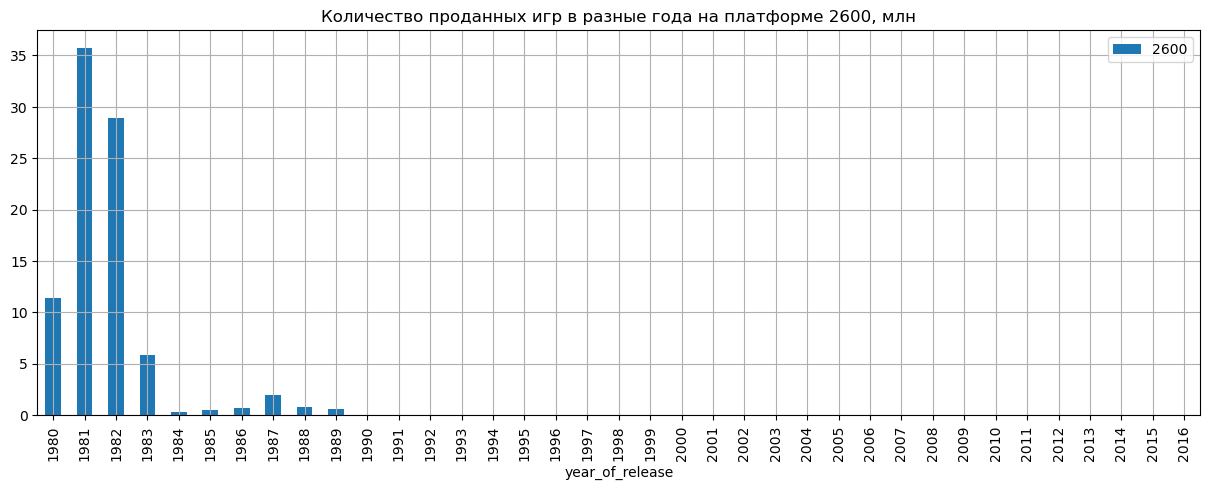

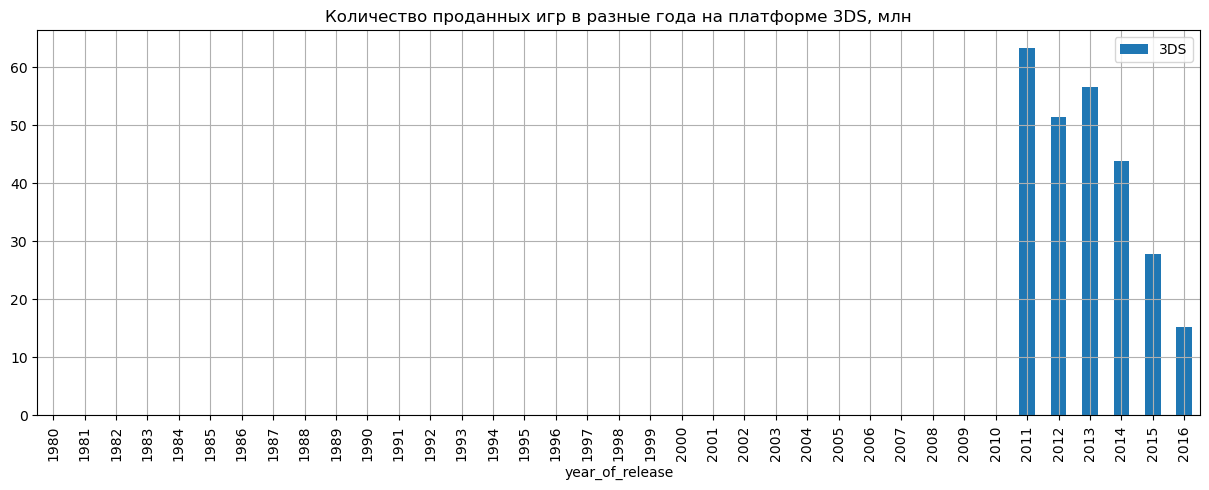

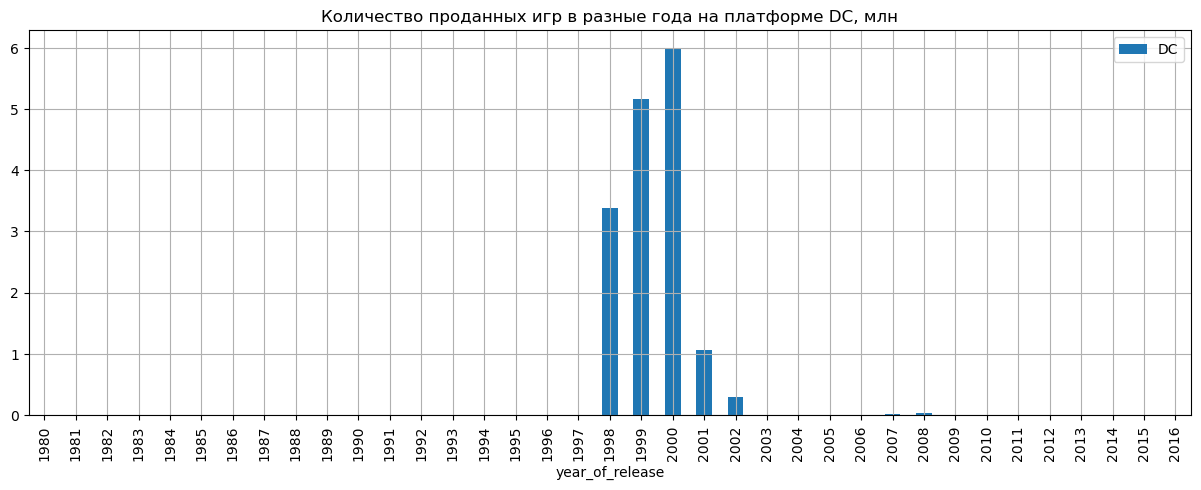

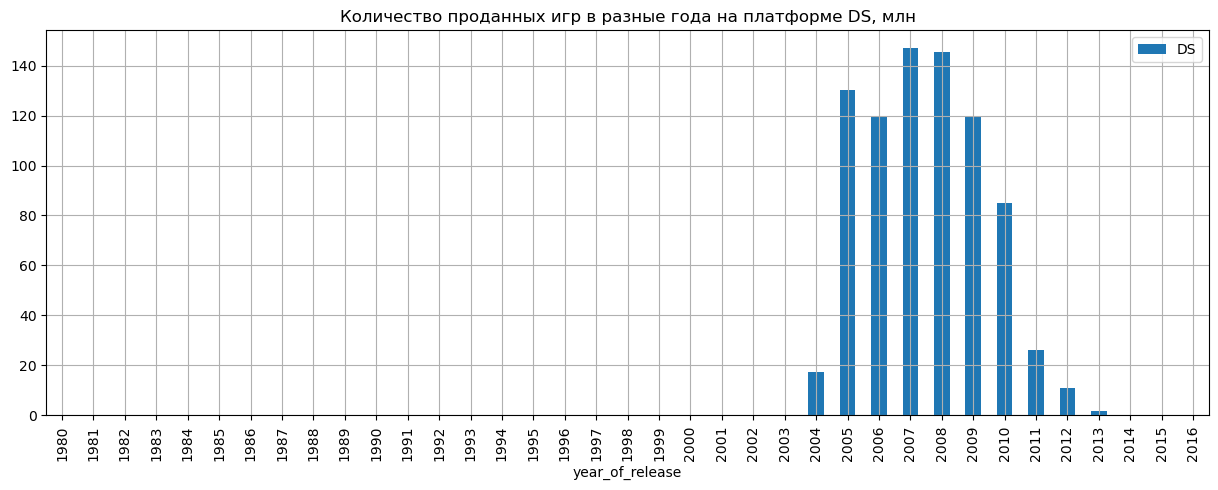

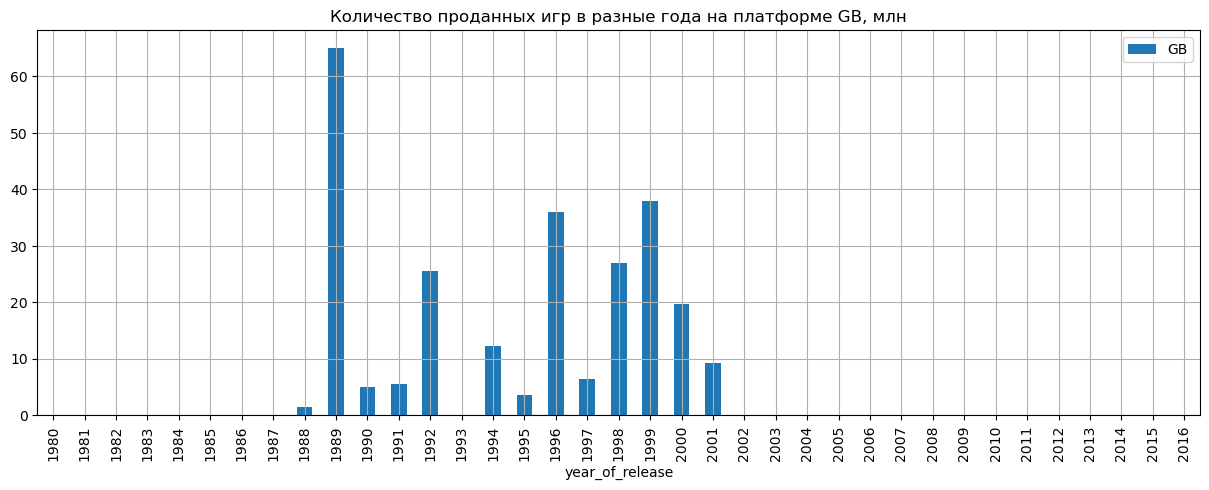

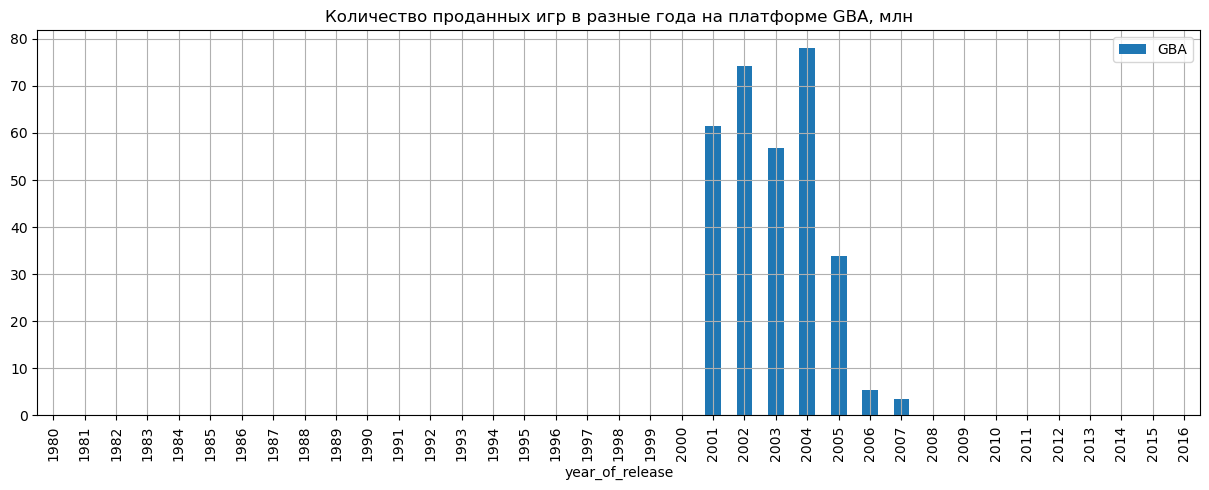

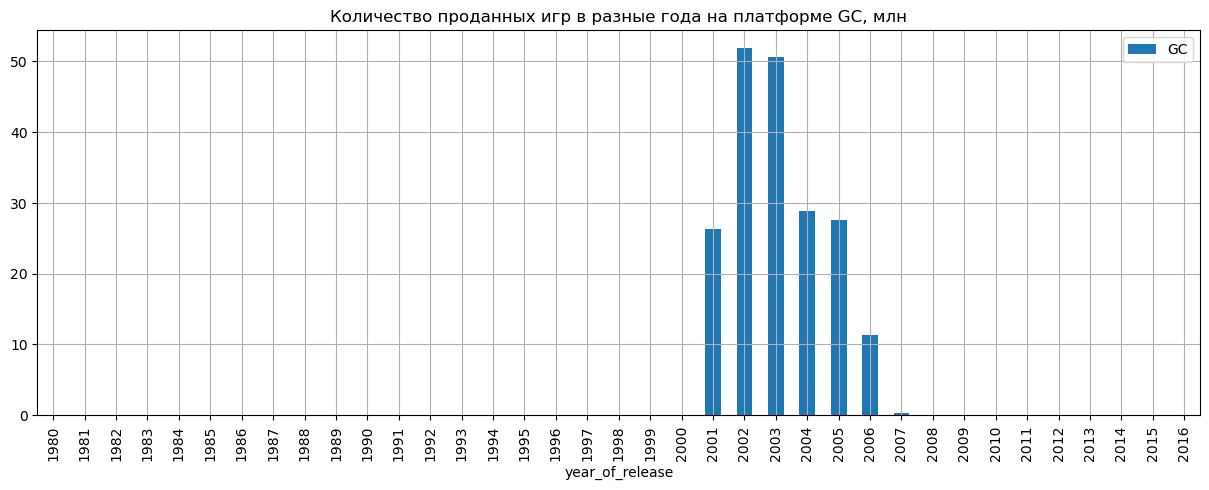

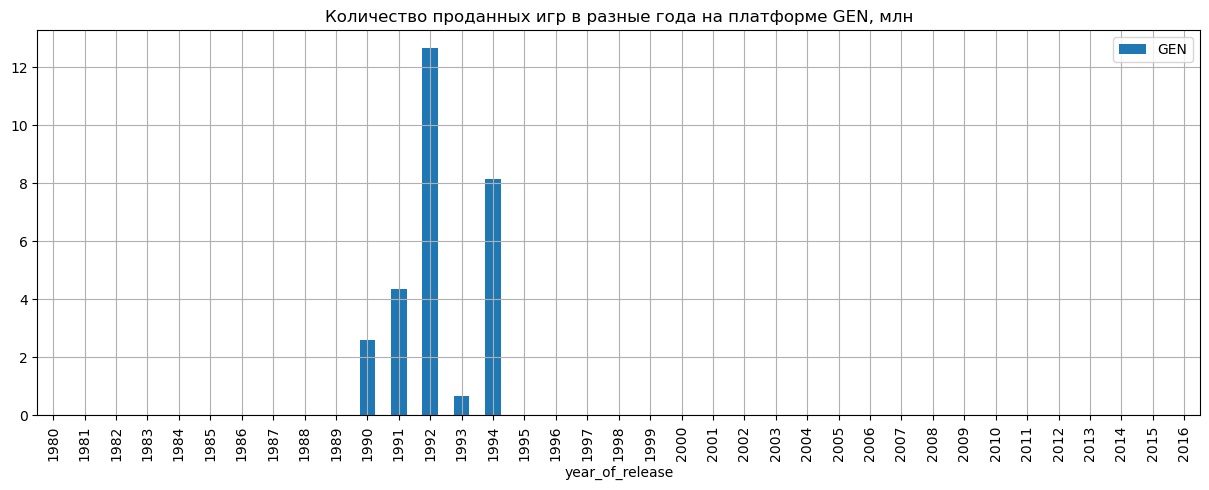

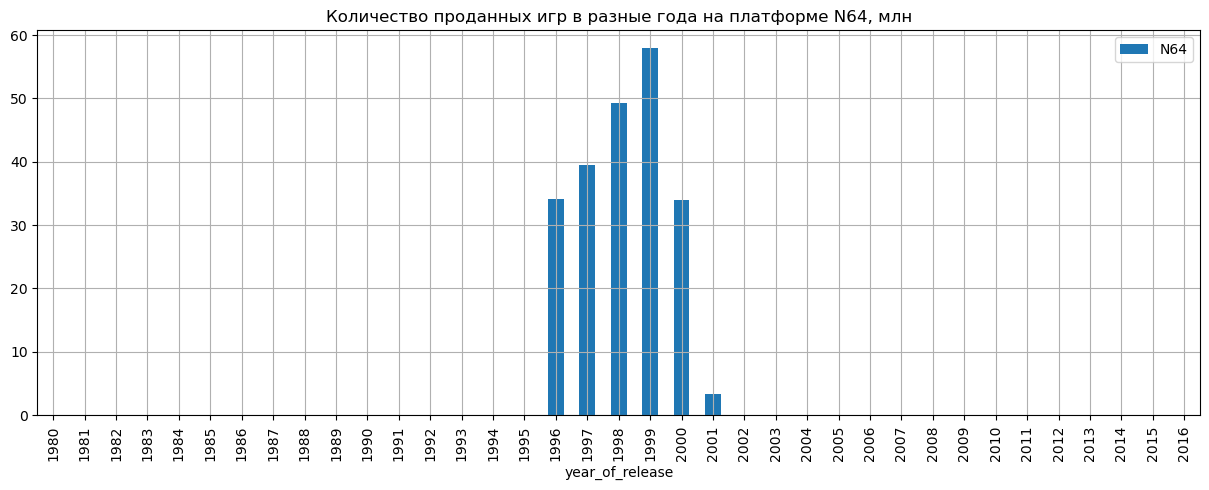

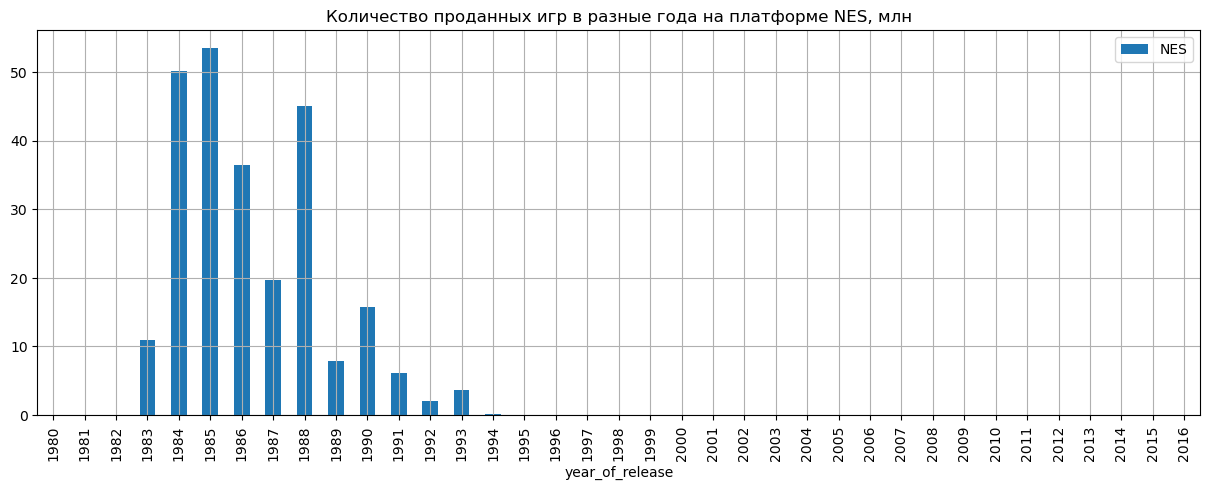

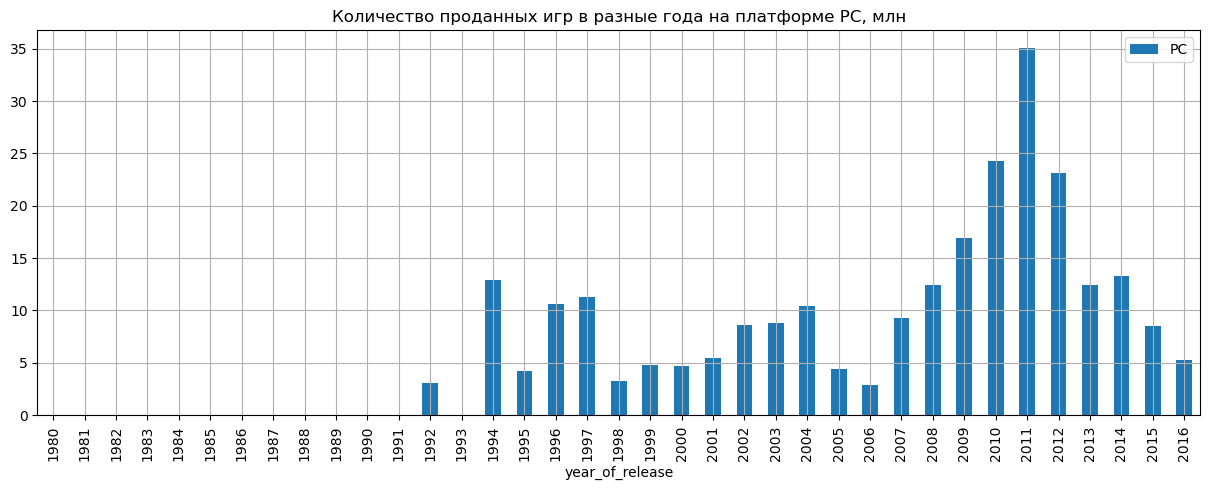

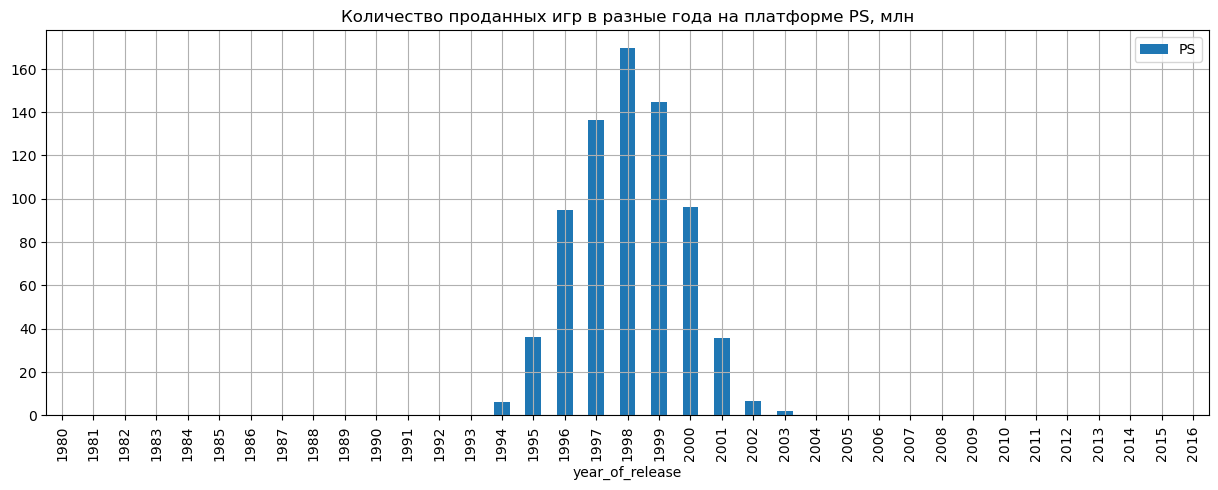

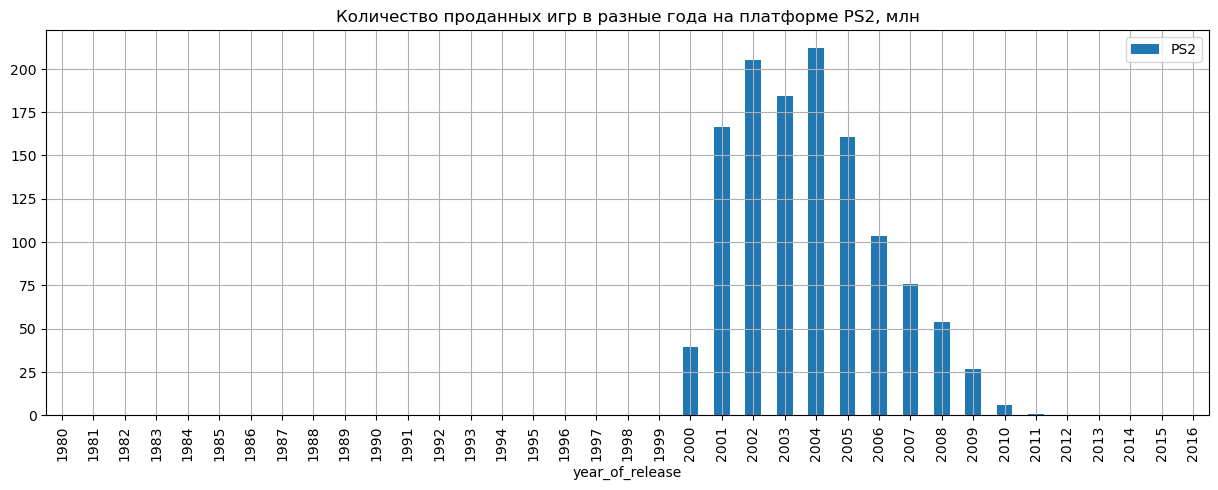

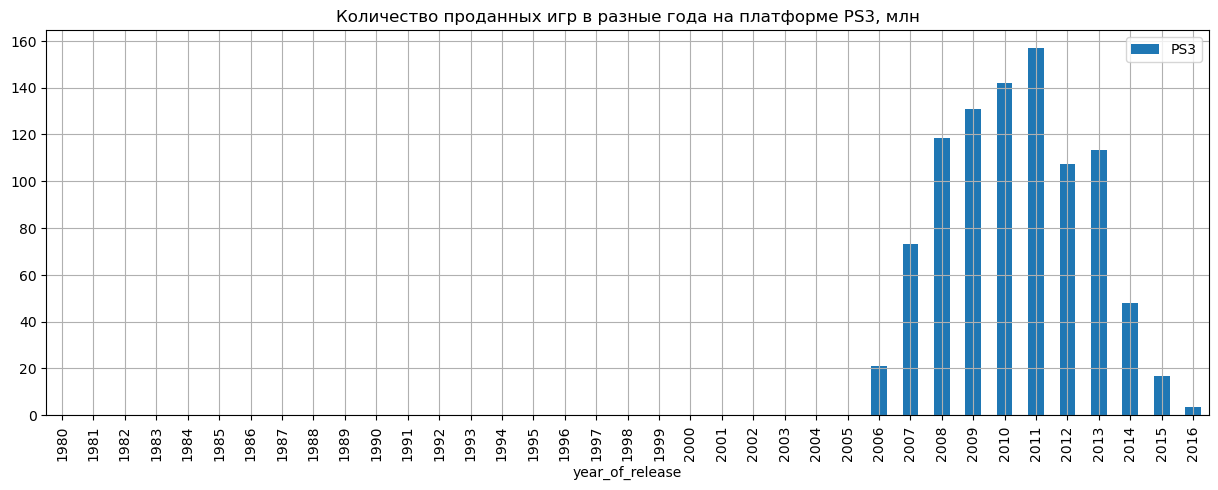

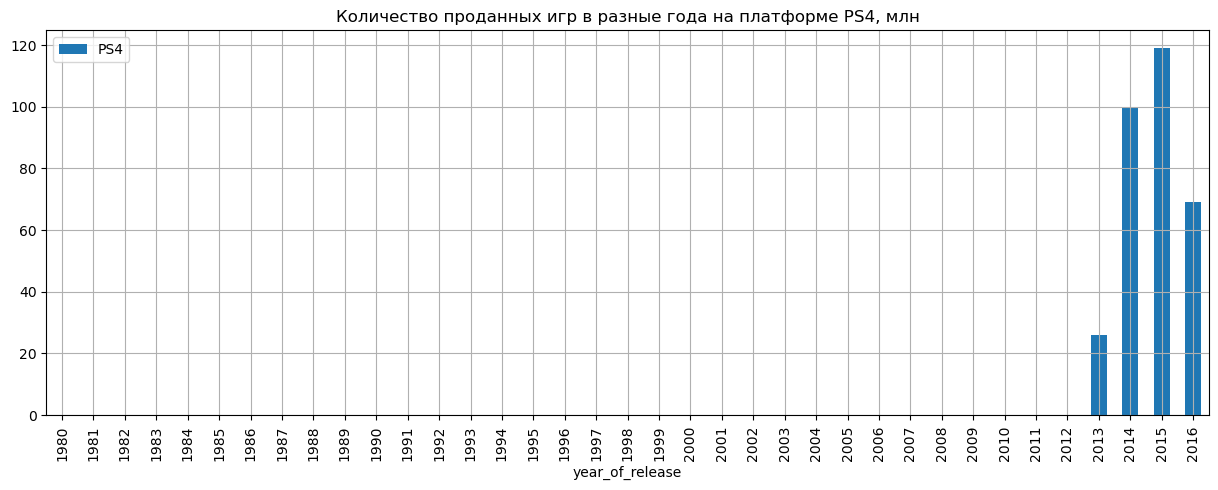

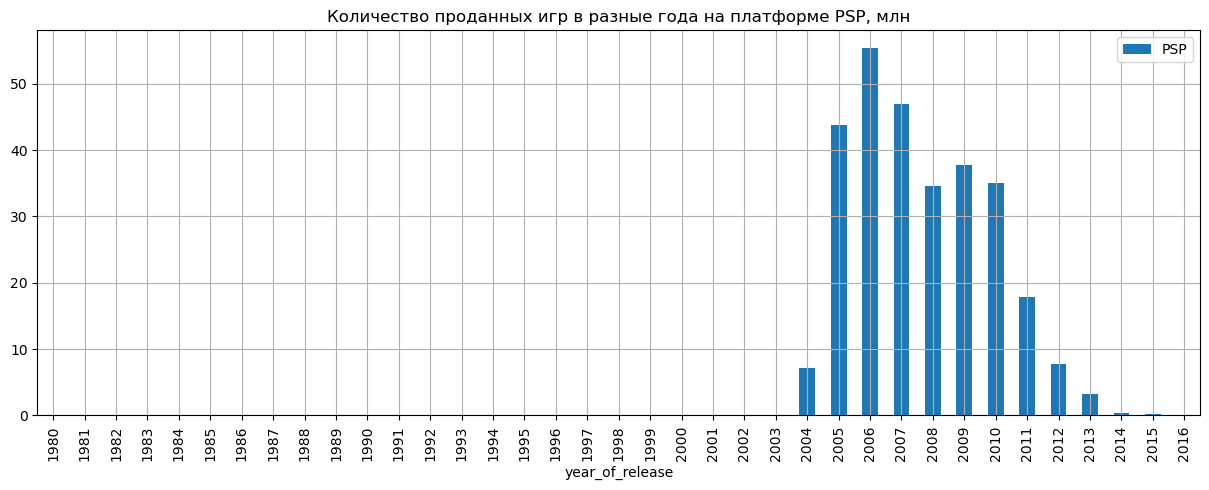

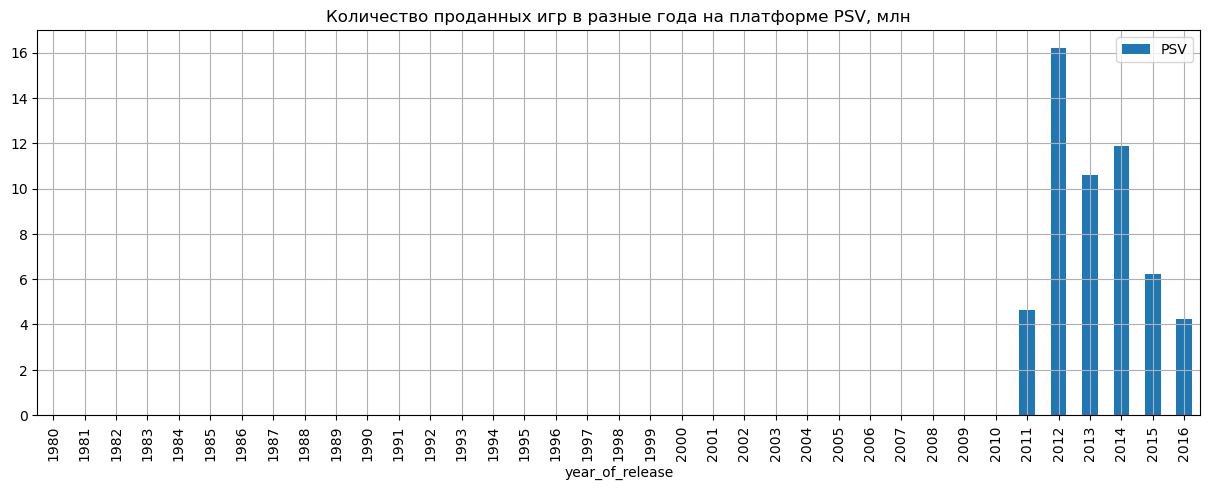

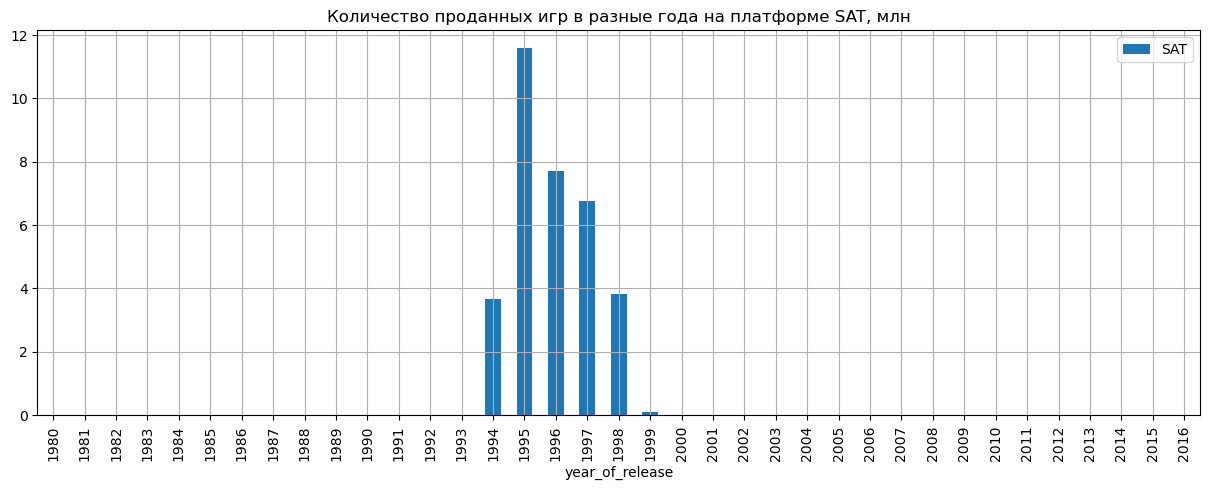

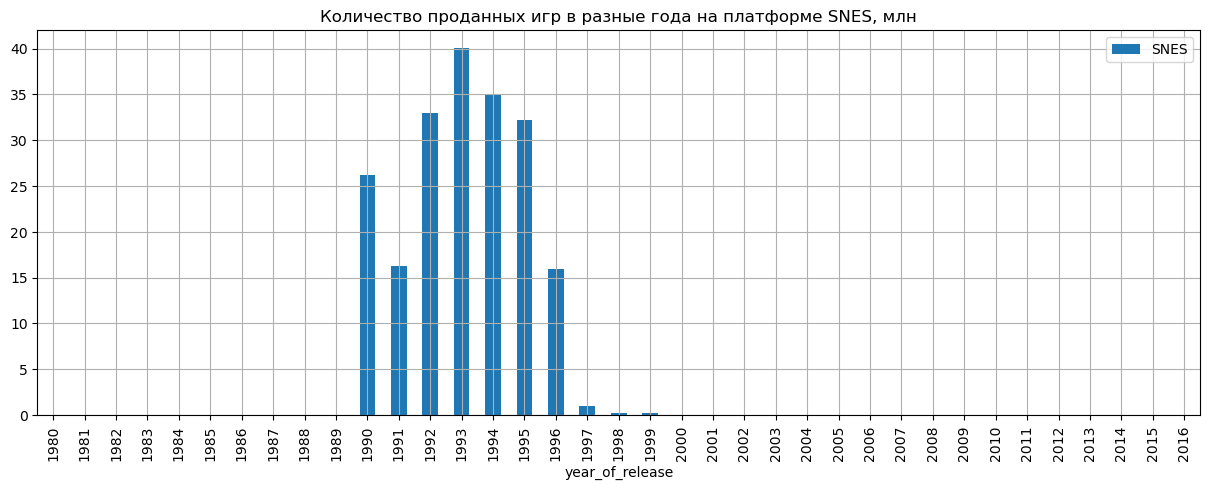

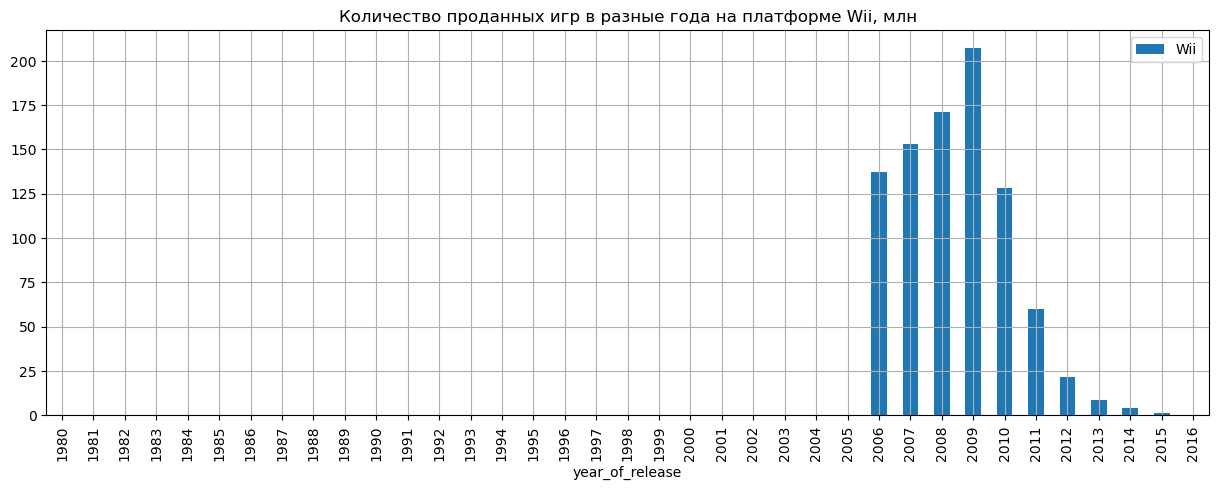

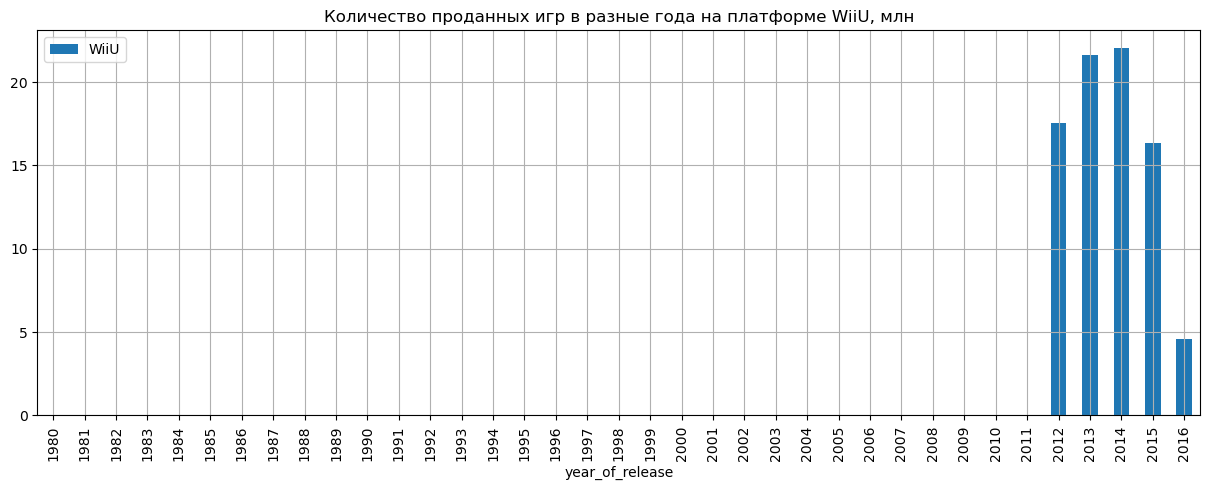

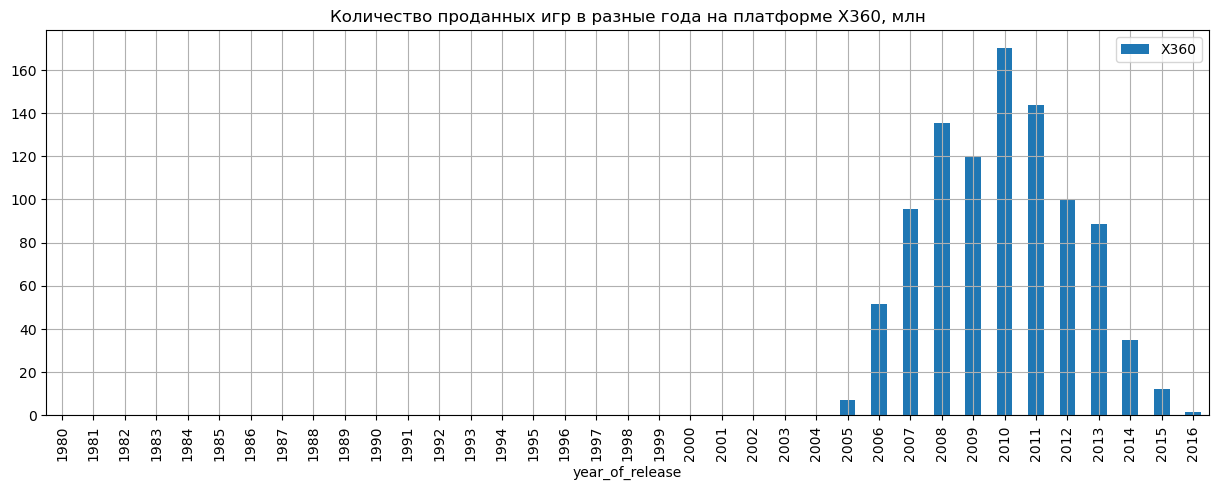

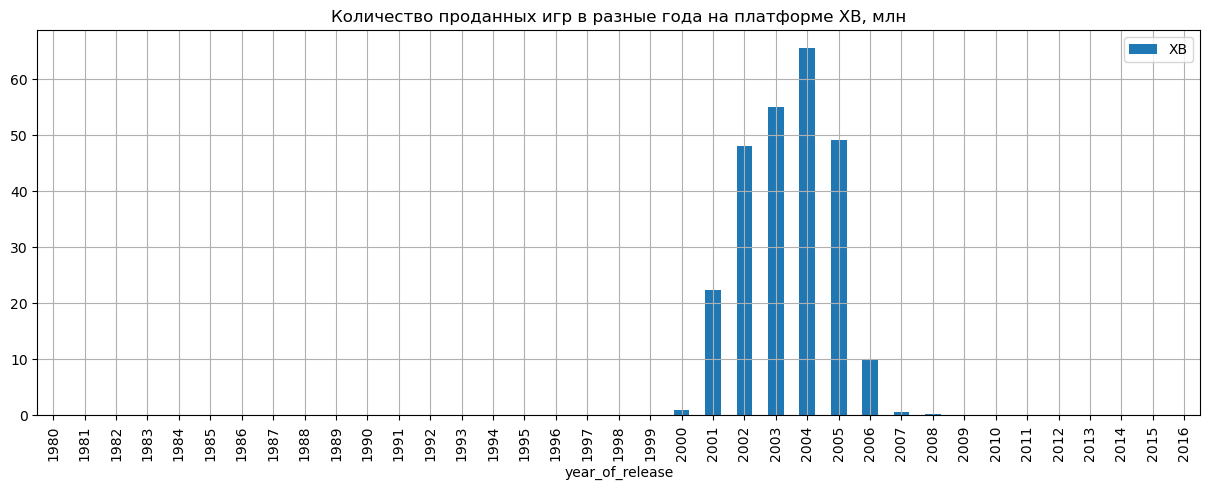

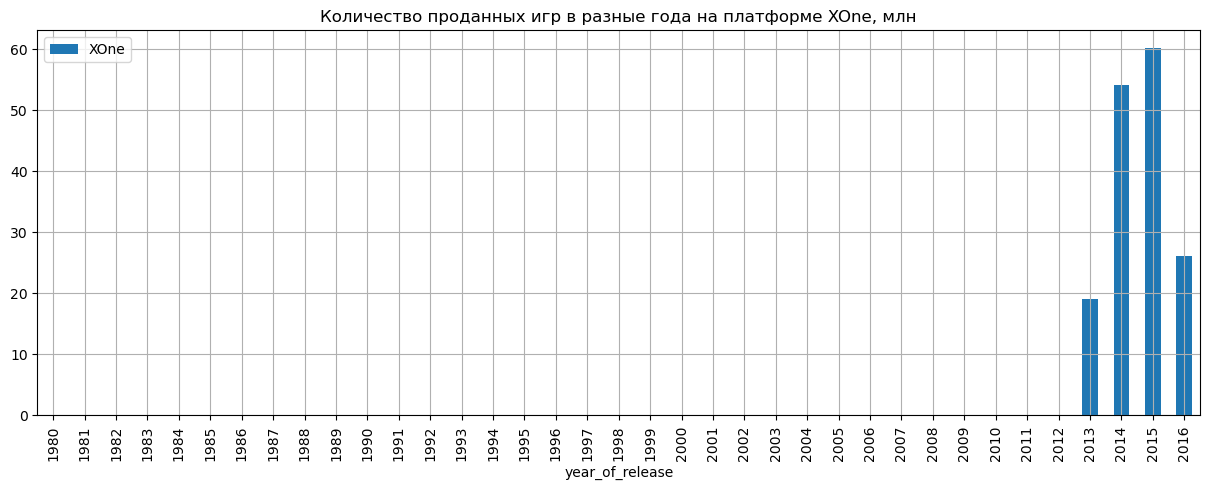

In [28]:
for platform in data_games_big_sales_of_year.columns:
    data_games_big_sales_of_year.plot(
        grid=True, y=platform, kind='bar', figsize=(15, 5), 
        title='Количество проданных игр в разные года на платформе ' + platform + ', млн'
    )
    pass

По графикам видно, что в среднем различные платформы живут от 5 до 10 лет, и в этом же промежутке появляются новые платформы, можно сделать вывод, что новые платформы чаще всего замещают собой старые, в следствии чего на старые платформы перестают выпускать игры, она перестает приносить прибыль и исчезает с рынка. 

Большие компании, как Sony и Microsoft выходят из этого пожелания, выпуская консоли нового поколения у которых лучше характеристики, которые позволяют на них разрабатывать более интереснее игры с лучшей графикой, механикой игр и т.д., по графикам по Playstation и Xbox можно заметить, что как компании выпускали консоль нового поколения, у старой консоли падают продажи игр, а у новой консоли наоборот растут.

Стоить отметить что среди всех графиков выделяется график по платформе PC, в 1993 году конечно на этой платформе либо вообще не выпускали игр, либо продали очень небольшое количество. Однако далее, продажи по платформе PC никогда не падали в очень низкие отметки, была просадка в 2006, но затем идет резкий скачок и до 2016 игры на платформе PC продаются и не падают до уровня 2006 года. Резкий скачок на данном графике связан с тем, что в 2006 Steam запустил партнерскую программу, однако начиная с 2011 года продажа игр на PC пошла на спад.

Для дальнейшего исследования, чтобы спланировать рекламную компанию на 2017 год, будем брать период за последние 4 года, то есть с 2013 по 2016 год, как раз в этот период будет самая актуальная информация по существующим платформам и проданным играм и за период в 4 года платформы не уходят с рынка.

Сделаем срез по годам с 2013 по 2016 и посмотрим какие платформы лидируют по продажам и выберем из них несколько потенциально прибыльных.

In [29]:
data_games_actual_period = data_games[data_games['year_of_release'] >= 2013]
data_games_actual_period.pivot_table(
    index='platform', columns='year_of_release', values='all_sales', aggfunc='sum')

year_of_release,2013,2014,2015,2016
platform,,,,
3DS,56.57,43.76,27.78,15.14
DS,1.54,NaN,NaN,NaN
PC,12.38,13.28,8.52,5.25
PS3,113.25,47.76,16.82,3.60
PS4,25.99,100.00,118.90,69.25
PSP,3.14,0.24,0.12,NaN
PSV,10.59,11.90,6.25,4.25
Wii,8.59,3.75,1.14,0.18
WiiU,21.65,22.03,16.35,4.60


Как видно по данным у всех платформ продажи по играм падают, есть даже две платформы у которых не было продаж в 2016 году, у одной из них продажи закончились в 2014 году. Больше всего по продажам выделяются платформы PS3 и PS4, есть года где у продано больше 100 милионнов копий игр, однако в начиная с 2014 у платформы PS3 падают продажи и в 2016 году они составляют 3.6 млн копий, что говорит о том, что через год-два платформа уйдет рынка, однако стоит отметить что в это момент растут продажи у платформы PS4. Аналогичная ситуация с платформами X360 и XOne, у первой в 2014 году продажи пошли на спад, а второй наоборот пошли верх, что также говорит о том, что платформа X360 скоро уйдет с рынка.

На основании выше изложенного выберем только те платформы у которых количество продаж в 2016 году начинается от 1 млн, это как раз будут те платформы, которые не уйдут с рынка в сдедующем году и по ним есть смысл делать рекламную кампанию, это следующие платформы - **3DS**, **PC**, **PS3**, **PS4**, **PSV**, **WiiU**, **X360**, **XOne**.

In [30]:
data_games_actual_period = data_games_actual_period[data_games_actual_period['platform'].isin(
    ['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'WiiU', 'X360', 'XOne'])]
data_games_actual_period

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16429,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16433,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16436,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16438,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


Посмотрим график «ящик с усами» по глобальным продажам игр в разбивке по платформам, чтобы понять какой порог по количеству проданных игр у каждой платформы. На графике количество «ящиков с усами» должно соответствовать количеству платформ, чтобы была возможность сравнить продажи между собой. Для построения графика будем использовать метод *boxplot* он позволяет построить сразу несколько «ящиков с усами» на одном графике.

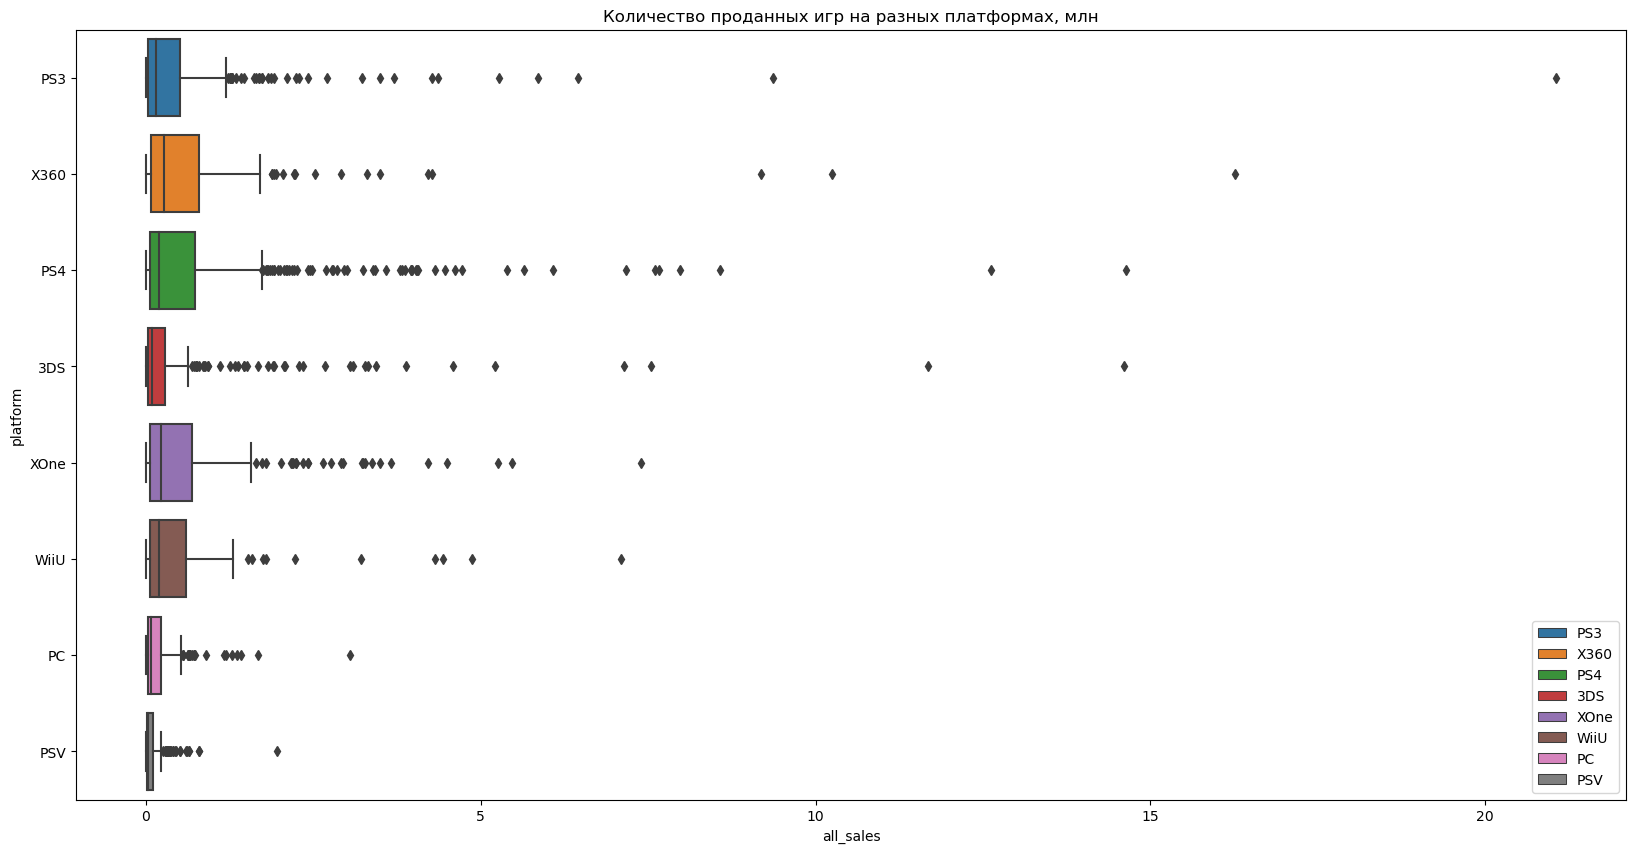

In [31]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Количество проданных игр на разных платформах, млн')
sns.boxplot(data=data_games_actual_period, x='all_sales', y='platform', orient="h", hue="platform", dodge=False)
plt.legend(loc='lower right')
pass

Для того чтобы точно определить порог нормальных значений, посторим ещё один график «ящик с усами» но уже с ограничением по проданным играм до 2 млн.

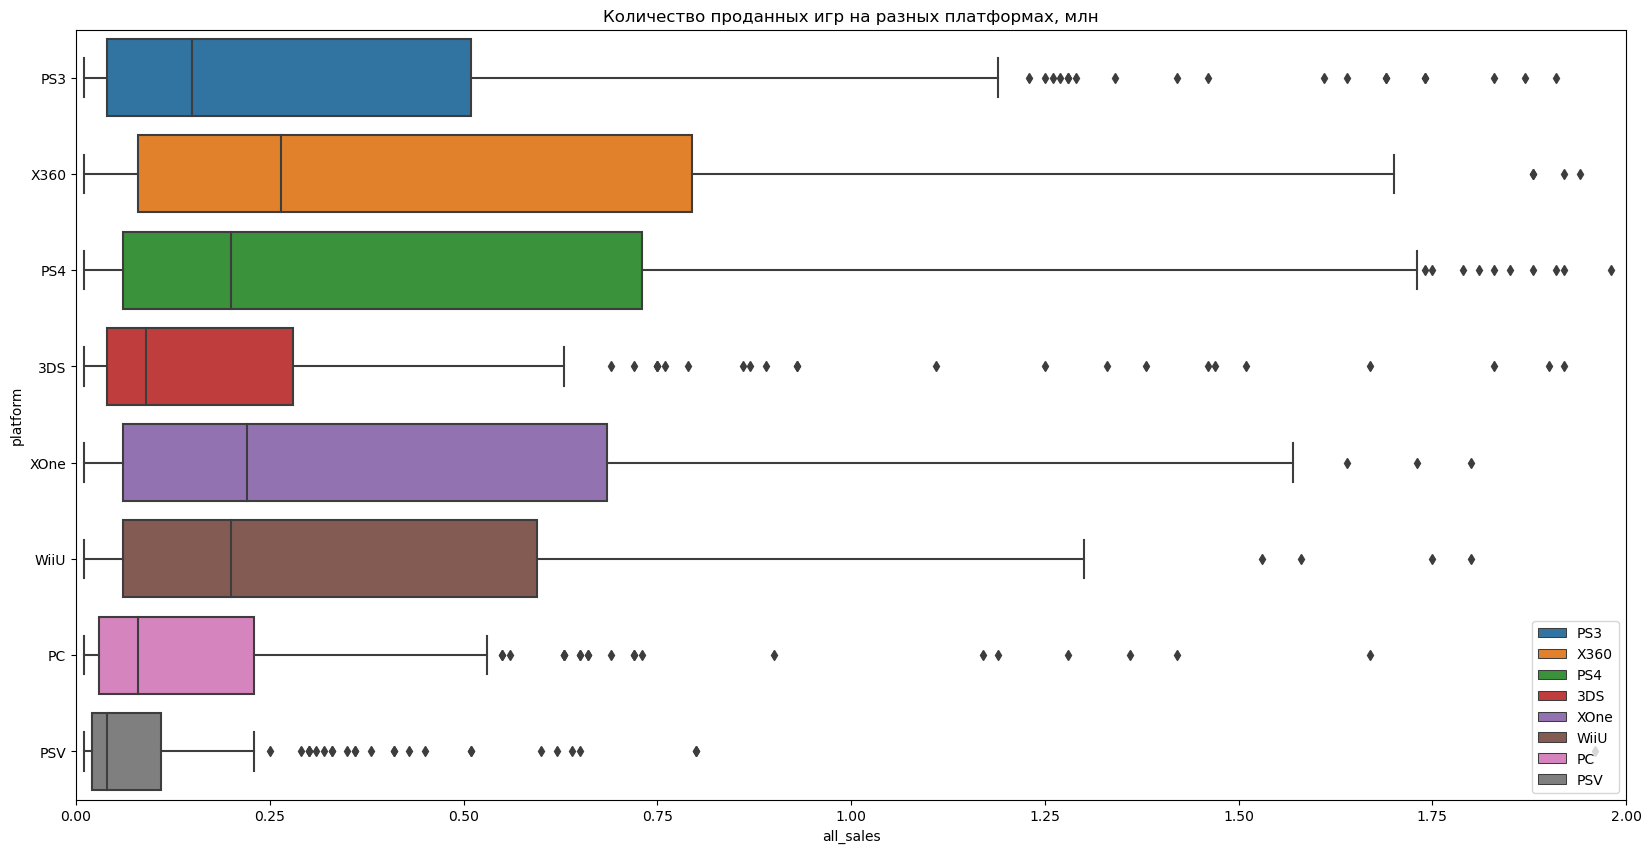

In [32]:
plt.xlim(0, 2.0)
plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Количество проданных игр на разных платформах, млн')
sns.boxplot(data=data_games_actual_period, x='all_sales', y='platform', orient="h", hue="platform", dodge=False)
plt.legend(loc='lower right')
pass

Добавим ещё один график с ограничениямии по проданным копиям игр до 0.85 млн, так мы сможем сранивать количество проданных игр у платформ у которых небольшое количество продаж.

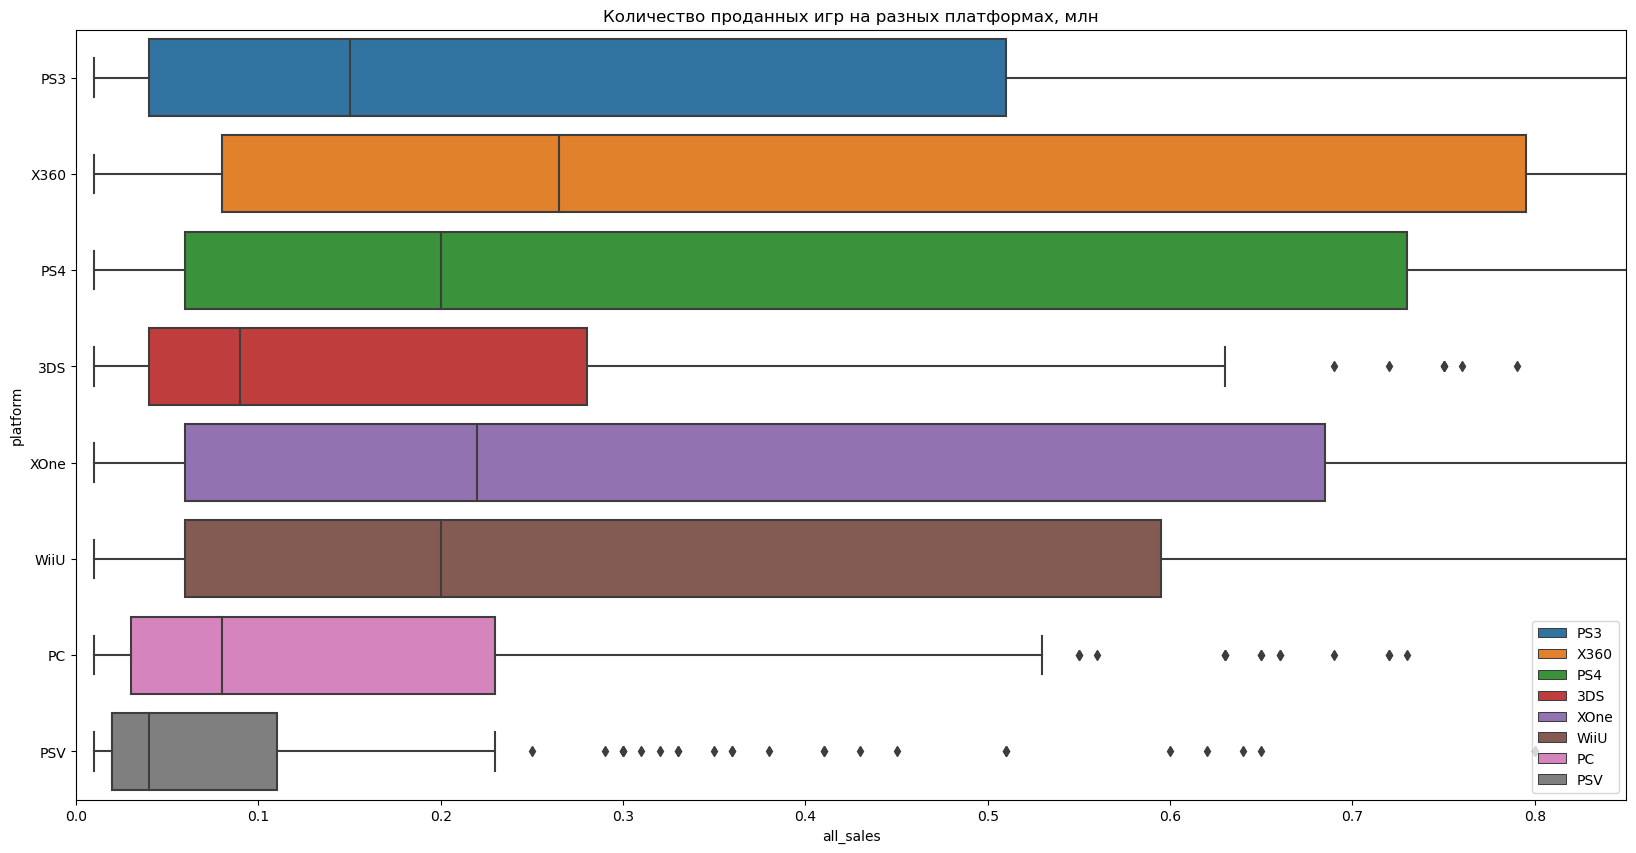

In [33]:
plt.xlim(0, 0.85)
plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Количество проданных игр на разных платформах, млн')
sns.boxplot(data=data_games_actual_period, x='all_sales', y='platform', orient="h", hue="platform", dodge=False)
plt.legend(loc='lower right')
pass

По графикам, где мы сделали ограничения по проданным играм, видно что нормальные значения по продажам игр у разных платформ находятся в диапазоне от 0.01 до 1.75 млн, больше всего на графике выделяются следующие платформы - **PS3**, **X360**, **PS4**, **XOne**. У **PS3** верхняя граница диапазона нормальных значений находится где-то у 1.25 млн, у **X360** возле 1.75 млн, у **PS4** также около 1.75 млн, но это граница ближе чем у **X360** и **XOne** чуть выше 1.5 млн. То есть, игра выпущенная на одну из таких платформ в среднем продается в количестве от 0.01 до 1.75 млн проданных копий за выбранный период с 2013 по 2016 год и среди всех платформ по проданным играм выделяется **PS4**, что логично, если мы вернемся к данным где смотрели количество проданных игр по годам, то увидим что у платформы **PS4** больше всего проданных игр.

Посмотри теперь на график, где нет ограничений по проданным играм, там заметно большое количество точек, то есть выбросов, за пределами диапазона нормальных значений, это те игры которые продались выше ожидаемого тиража. Здесь больше всего выделяется платформа **3DS**, хоть на ней в среднем количество проданных игр составляет максимум 0.75 млн проданных копий, но у неё большое количество игр продалось выше ожидаемого результата. Также по количеству проданных игр выше ожидаемого выделяются платформы **PS4**, **PS3**, **X360** и **XOne**, видимо выход различных экслюзнивных игр на игровые приставки приносит свои результаты и помогает делать продажи выше ожидаемых.

На последних местах у нас платформы **PC**, **WiiU** и **PSV**. Как мы помним из графика по проданным играм на платформе **PC**, начиная с 2007 года идет рост продаж и в 2011 году он достигает своего пика, и начиная с 2012 год это рост идет на спад, платформы **PC** начинают замещать игровые консоли с экслюзнивные играми, которые на **PC** выпускают примерно через 2 года, но могут и не выпустить на ПК. Купить игровую консоль становится дешевле чем **PC** на котором можно будет играть в современные игры, в следствии чего количество проданных игр на **PC** падает, но как было заметно на графиках ранее, **PC** - это уникальная платформа, с 1994 года на неё стабильно покупают игры, в отличие от игровых консолей.

Платформы **PSV** и **3DS** представляют собой портативные платформы и судя по графикам **3DS** заменит **PSV**, так как у **PSV** среднее количество проданных копий игр находится в диапазоне 0.01 до 0.25 млн, и у этой платформы наименьшее значение медианы, что говорит о том, что платформа в скором времени уйдет с рынка.

По платформе **WiiU** видно что в среднем на ней продается около 1.25 копий игр, однако, если посмотреть на график, где нет ограничений по количеству проданных игр, видно что у этой платформы самое маленькое количество проданных игр выше запланированого по сравнению с другими платформами, что говорит о том, что эта платформа не приносит много прибыли и в ближайшее время уйдет с рынка.

Посмотрим теперь влияют ли оценки пользователя и критиков на количество проданных игр. Построим диаграмму рассеяния по количеству в зависимости от оценки пользователей и критиков по самой популярной платформе у которой покупали больше всего игр **PS4**:

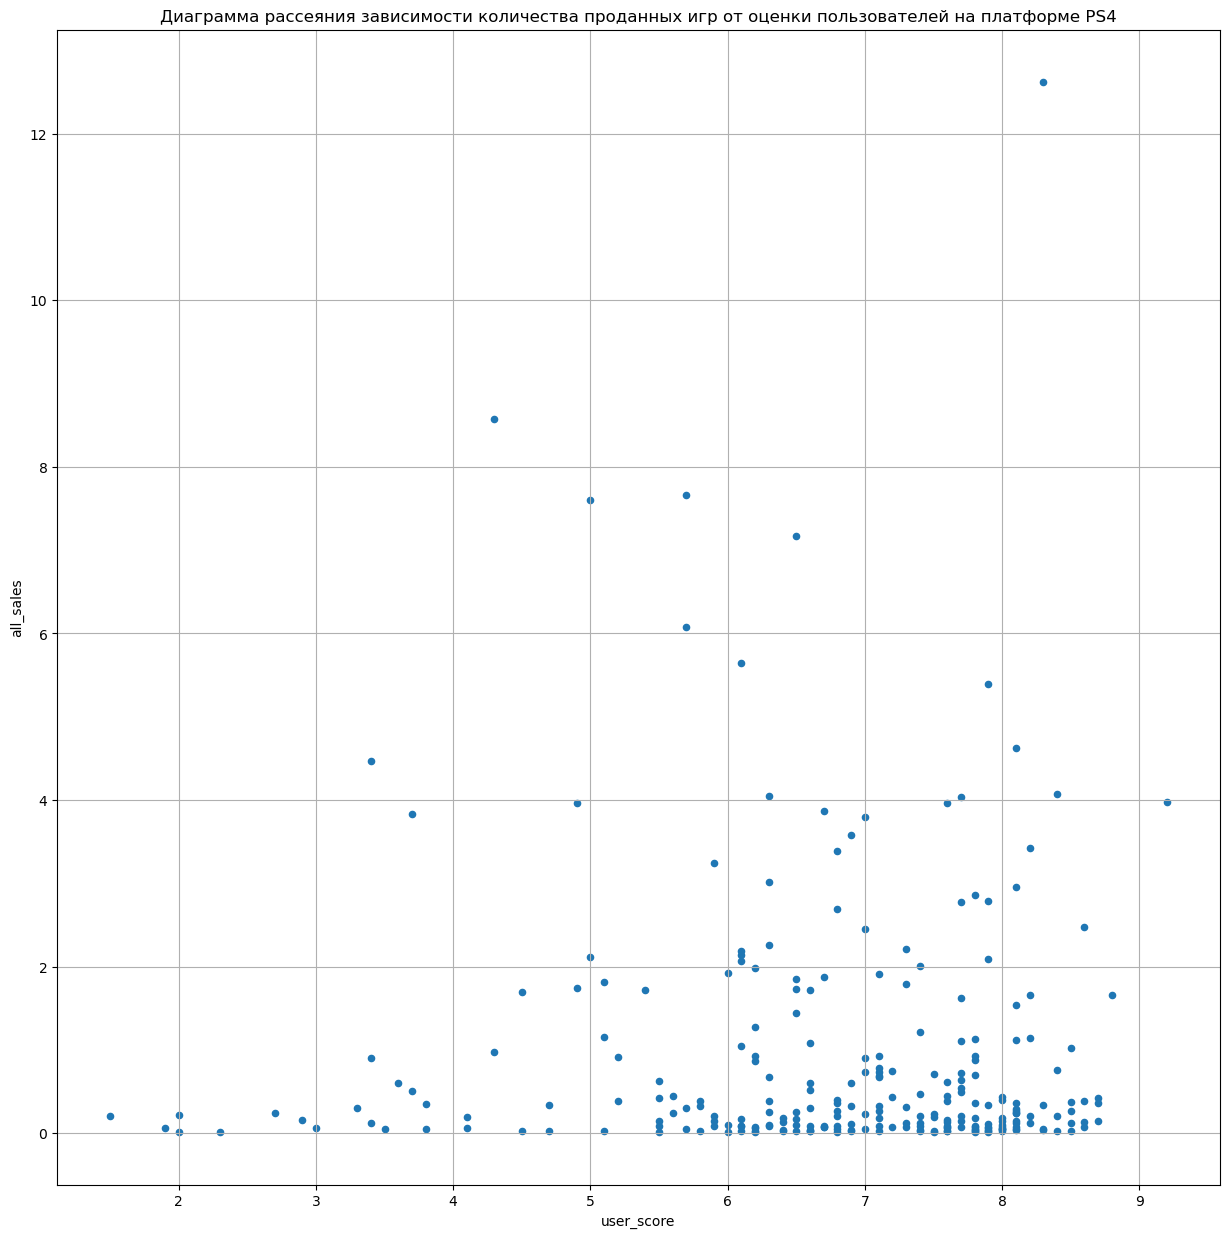

In [34]:
data_games_actual_period[(data_games_actual_period['platform'] == 'PS4')].plot(
    x='user_score', y='all_sales', kind='scatter', figsize=(15, 15), grid=True,
    title='Диаграмма рассеяния зависимости количества проданных игр от оценки пользователей на платформе PS4')
pass

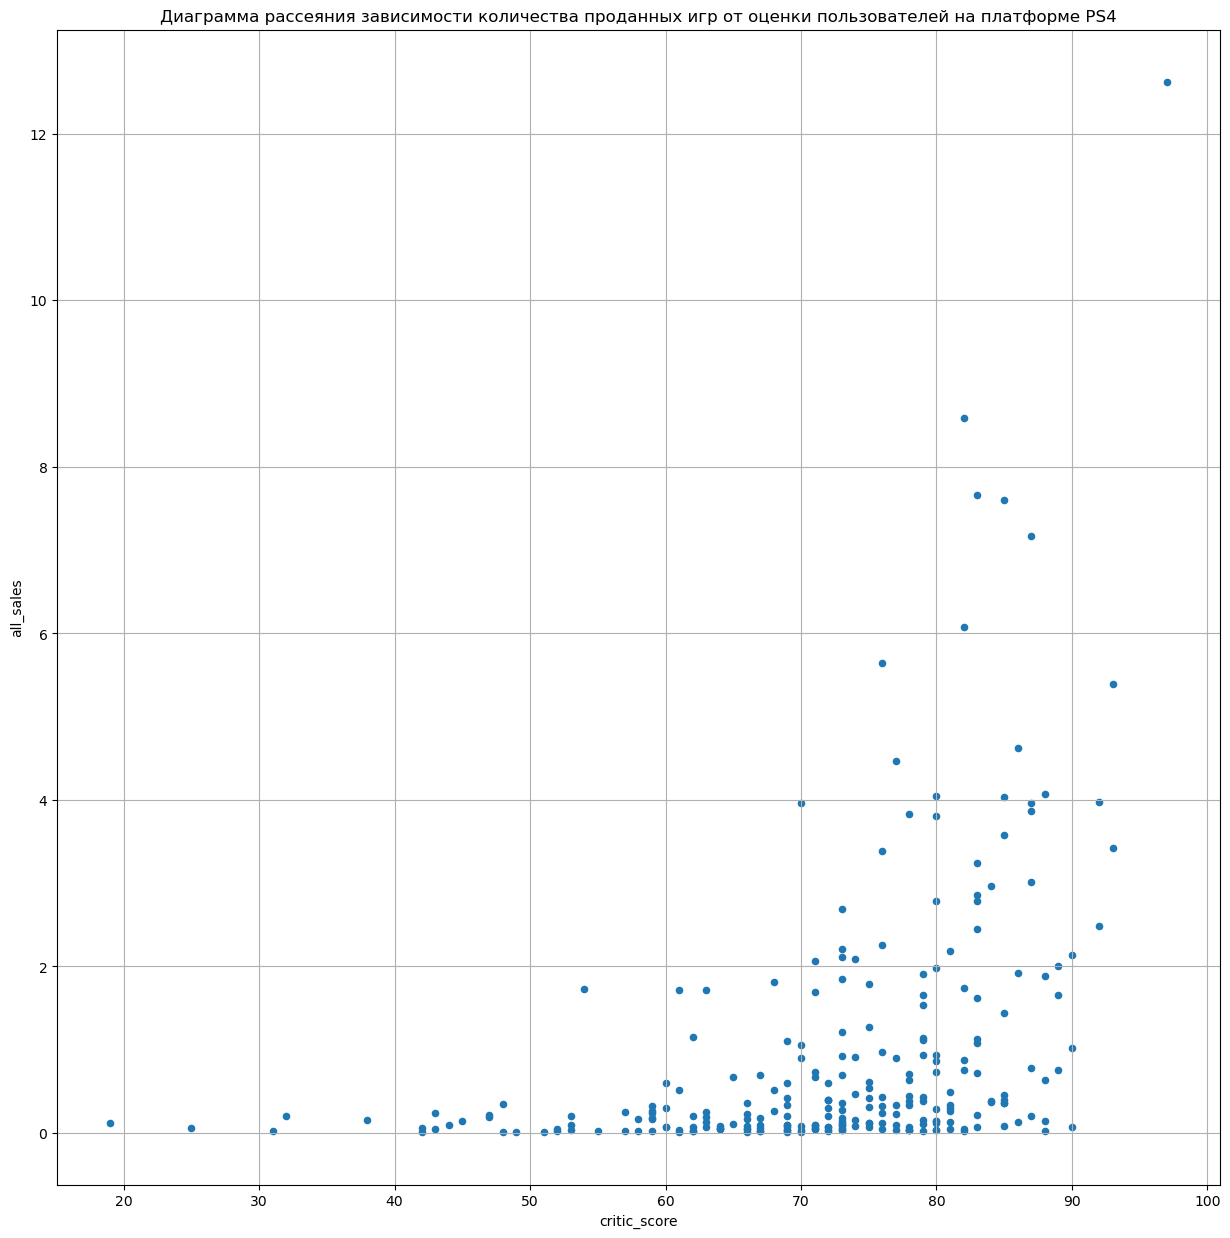

In [35]:
data_games_actual_period[data_games_actual_period['platform'] == 'PS4'].plot(
    x='critic_score', y='all_sales', kind='scatter', figsize=(15, 15), grid=True,
    title='Диаграмма рассеяния зависимости количества проданных игр от оценки пользователей на платформе PS4')
pass

По графикам видно, что количество продаж больше зависит от оценки критиков, чем от оценки пользователей, на графике по оценкам критиков точки больше смещено вправо, а на графике по оценке пользователей нет заметного смещения точек в правую или в левую сторону на графике. Также можно заметить игры, у которых средняя оценка от пользователей меньше, а количество проданных копий игр больше 5 млн, на графике по оценке критиков такого нет, большинство игр, которые получили оценку от критиков меньше 70 имеют количество проданных копий меньше 2 млн. 

Проверим наше предположение с помощью корреляций зависимости продаж от оценки пользователей и критиков, для этого будем рассчитывать коэффициента Пирсона, чем ближе этот коэффициент к 1 или -1, тем теснее линейная взаимосвязь.

In [36]:
print('Коэффициент Пирсона по оценке пользователей:', 
      data_games_actual_period[data_games_actual_period['platform'] == 'PS4']['all_sales'].corr(
          data_games_actual_period['user_score']))
print('Коэффициент Пирсона по оценке критиков:',
      data_games_actual_period[data_games_actual_period['platform'] == 'PS4']['all_sales'].corr(
          data_games_actual_period['critic_score']))

Коэффициент Пирсона по оценке пользователей: -0.031957110204556376
Коэффициент Пирсона по оценке критиков: 0.406567902061781


Как видно по корреляциям есть слабая прямая взаимосвязь есть между оценкой критиков и количеством продаж, а вот между оценкой пользователей и количеством продаж взаимосвязи нет, так как её значение находится возле нуля. 

Посмотри корреляции по оценкам у других платформ:

In [37]:
for platform in data_games_actual_period['platform'].unique():
    print('Коэффициент Пирсона по оценке пользователей на платформе ' + platform + ':', 
      data_games_actual_period[data_games_actual_period['platform'] == platform]['all_sales'].corr(
          data_games_actual_period['user_score']))
    print('Коэффициент Пирсона по оценке критиков на платформе ' + platform + ':',
          data_games_actual_period[data_games_actual_period['platform'] == platform]['all_sales'].corr(
              data_games_actual_period['critic_score']))

Коэффициент Пирсона по оценке пользователей на платформе PS3: 0.0023944027357566925
Коэффициент Пирсона по оценке критиков на платформе PS3: 0.3342853393371919
Коэффициент Пирсона по оценке пользователей на платформе X360: -0.011742185147181342
Коэффициент Пирсона по оценке критиков на платформе X360: 0.3503445460228664
Коэффициент Пирсона по оценке пользователей на платформе PS4: -0.031957110204556376
Коэффициент Пирсона по оценке критиков на платформе PS4: 0.406567902061781
Коэффициент Пирсона по оценке пользователей на платформе 3DS: 0.24150411773563016
Коэффициент Пирсона по оценке критиков на платформе 3DS: 0.35705661422881035
Коэффициент Пирсона по оценке пользователей на платформе XOne: -0.06892505328279412
Коэффициент Пирсона по оценке критиков на платформе XOne: 0.41699832800840175
Коэффициент Пирсона по оценке пользователей на платформе WiiU: 0.4193304819266187
Коэффициент Пирсона по оценке критиков на платформе WiiU: 0.3764149065423912
Коэффициент Пирсона по оценке пользоват

Как видно по остальным корреляциям у других платформам тоже есть слабая взаимосязь между количеством продаж и оценкой критиков, а взаимосвязи между оценкой пользователей и количеством продаж нет, либо она очень слабая.

С оценками разобрались, посмотрим теперь самые популярные жанры игр по количество продаж в разных жанрах. Для сравнения возьмем медиану по количеству продаж в разных жанрах, будем брать медиану, потому на неё не влияет слишком большие или слишком маленькие значения в отличие от среднего.

In [38]:
data_games_actual_period.groupby('genre')['all_sales'].median() * 100

genre
Action          11.0
Adventure        3.0
Fighting        13.0
Misc            11.0
Platform        22.5
Puzzle           6.0
Racing          12.0
Role-Playing    12.0
Shooter         45.0
Simulation       9.5
Sports          24.0
Strategy         8.0
Name: all_sales, dtype: float64

Как видно по данным больше всего по продажам выделяются жанры **Shooter**, **Sports**, **Platform**, **Fighting** они имеют высокий уровень продаж по сравнению с остальными жанрами, больше всего по продажам выделяется жанр **Shooter**. Самые низкие продажи имеют жанры **Puzzle** и **Adventure**, самый низкий уровень продаж у жанра **Adventure**.

### Портрет пользователя каждого региона

Определим портрет пользователя в каждом регионе. Для этого сначала определим топ-5 платформ в различных регионах по количеству проданных игр с помощью графиков гистограмм. 

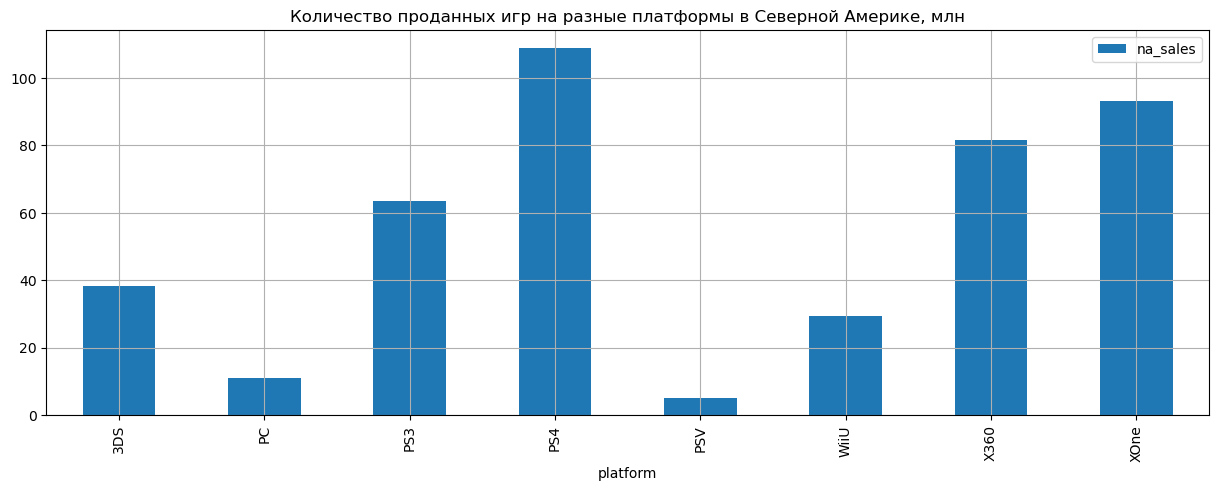

In [39]:
data_games_actual_period.pivot_table(index='platform', values='na_sales', aggfunc='sum').plot(
    grid=True, y='na_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр на разные платформы в Северной Америке, млн'
)
pass

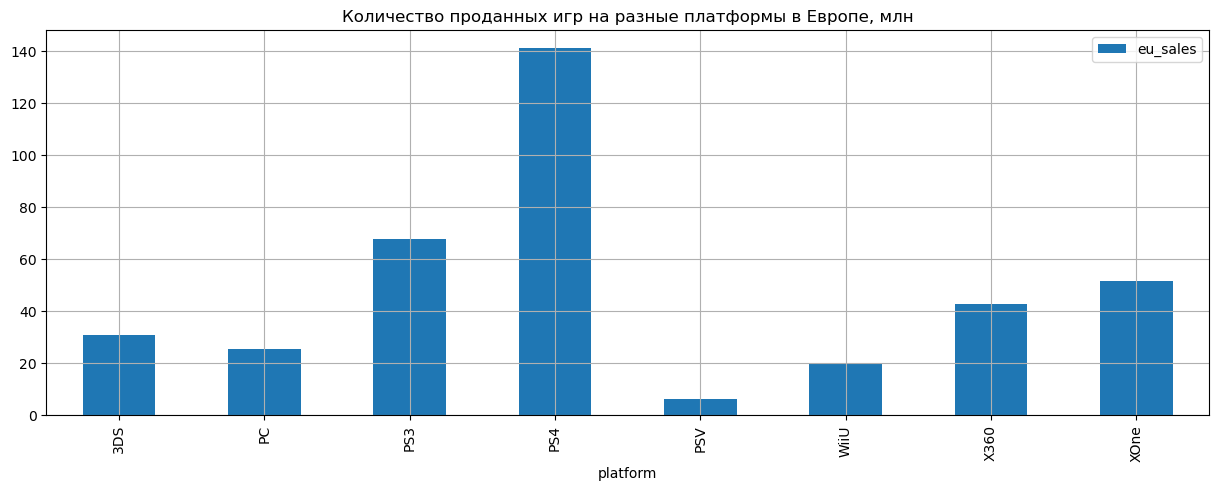

In [40]:
data_games_actual_period.pivot_table(index='platform', values='eu_sales', aggfunc='sum').plot(
    grid=True, y='eu_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр на разные платформы в Европе, млн'
)
pass

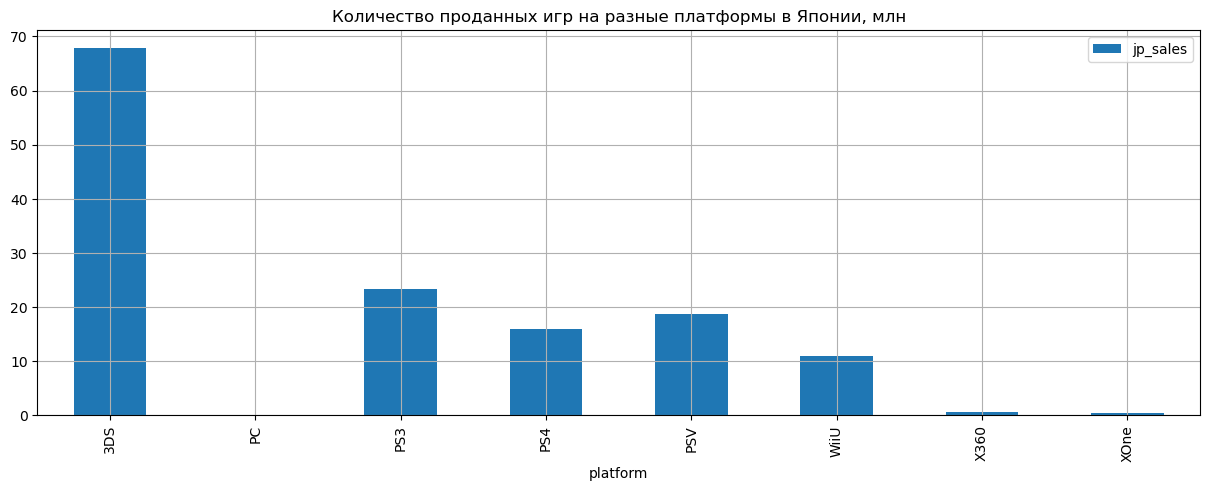

In [41]:
data_games_actual_period.pivot_table(index='platform', values='jp_sales', aggfunc='sum').plot(
    grid=True, y='jp_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр на разные платформы в Японии, млн'
)
pass

По графикам можно сделать следующие выводы по топ-5 платформ в различных регионах:
- Северная Америка - **PS4**, **XOne**, **X360**, **PS3**, **3DS**;
- Европа - **PS4**, **PS3**, **XOne**, **X360**, **3DS**;
- Япония - **3DS**, **PS3**, **PSV**, **PS4**, **WiiU**.

В Северной Америке и Европе одинаковый топ-5 плафторм, только отличается количество продаж среди топа платформ, также в Европе сильно популярня платформа **PS4** по сравнению с другими платформами, отрыв по продажам по сравнению с остальными платформами минимум больше в два раза. В Северной Америке в топе платформ выделяются **PS4**, **XOne** можно сказать что эти платформы имеют не сильно большой разрыв по продаж и они даже могут поменяться местами по количеству продаж в будущих годах. 

В Японии больше всего предпочитают портативную платформу **3DS**, лидер по количеству продаж, в Японии не так популярна платформа **PS4** по сравнению с Северной Америкой и Европой, тут платформа **PS4** стоит на предпоследнем месте в топ-5. Также в Японии платформа **PSV** находится на третьем месте среди топ-5 по количеству продаж, вероятно в Японии очень популярные различные портативные приставки, которые можно брать с собой в разичные места и играть в них, скорее всего это связано с другим ритмом жизни по сравнению с Северной Америкой или в Европе.

Построить теперь аналогичные графики, только по жанрам, определить в каких регионы топ-5 популярных жанров игр

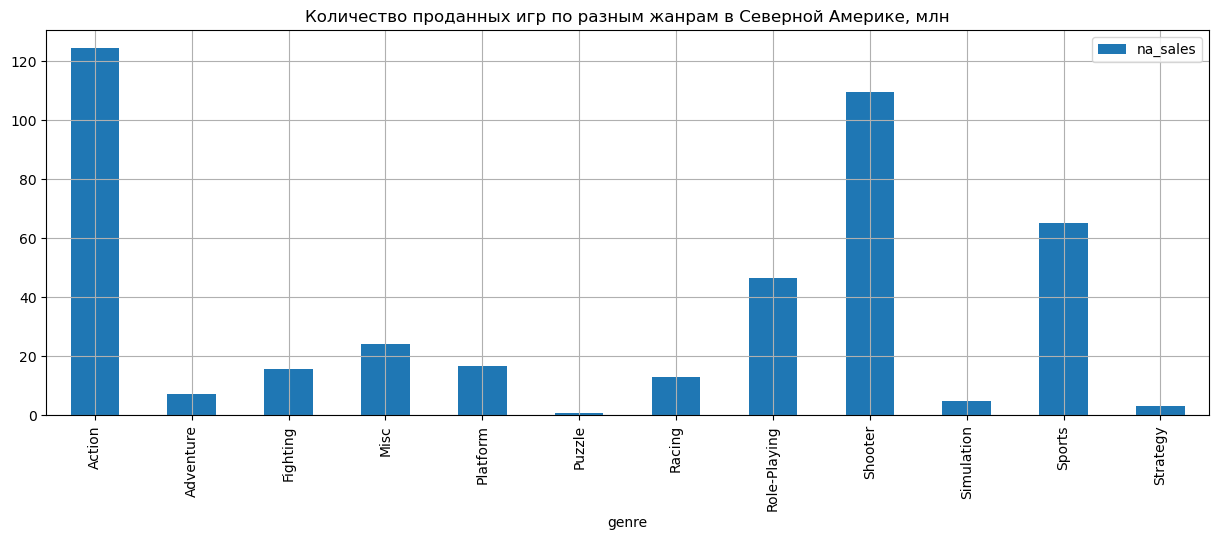

In [42]:
data_games_actual_period.pivot_table(index='genre', values='na_sales', aggfunc='sum').plot(
    grid=True, y='na_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр по разным жанрам в Северной Америке, млн'
)
pass

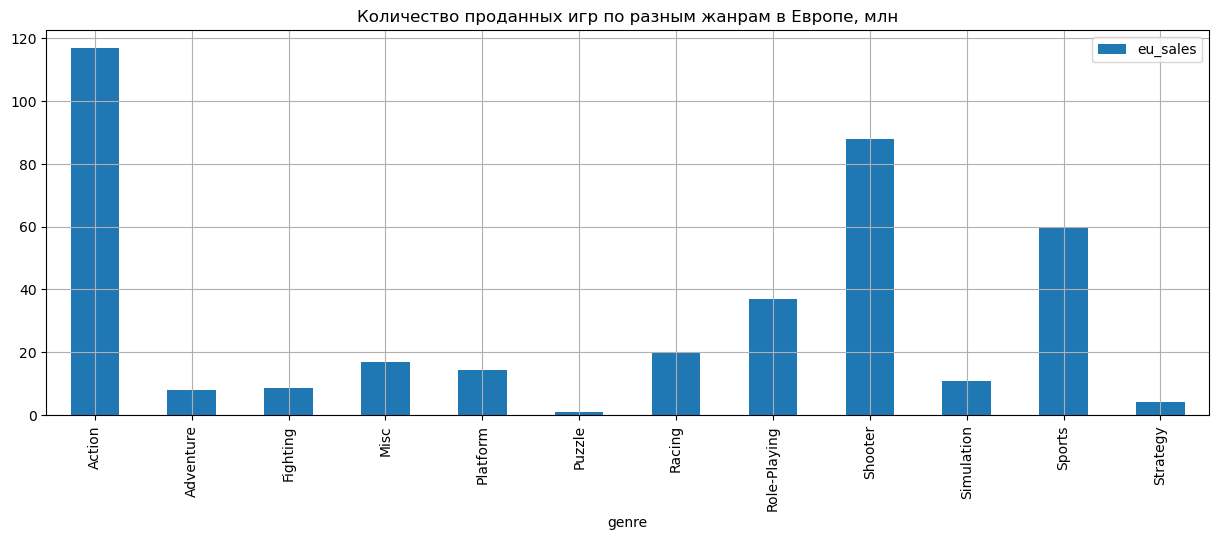

In [43]:
data_games_actual_period.pivot_table(index='genre', values='eu_sales', aggfunc='sum').plot(
    grid=True, y='eu_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр по разным жанрам в Европе, млн'
)
pass

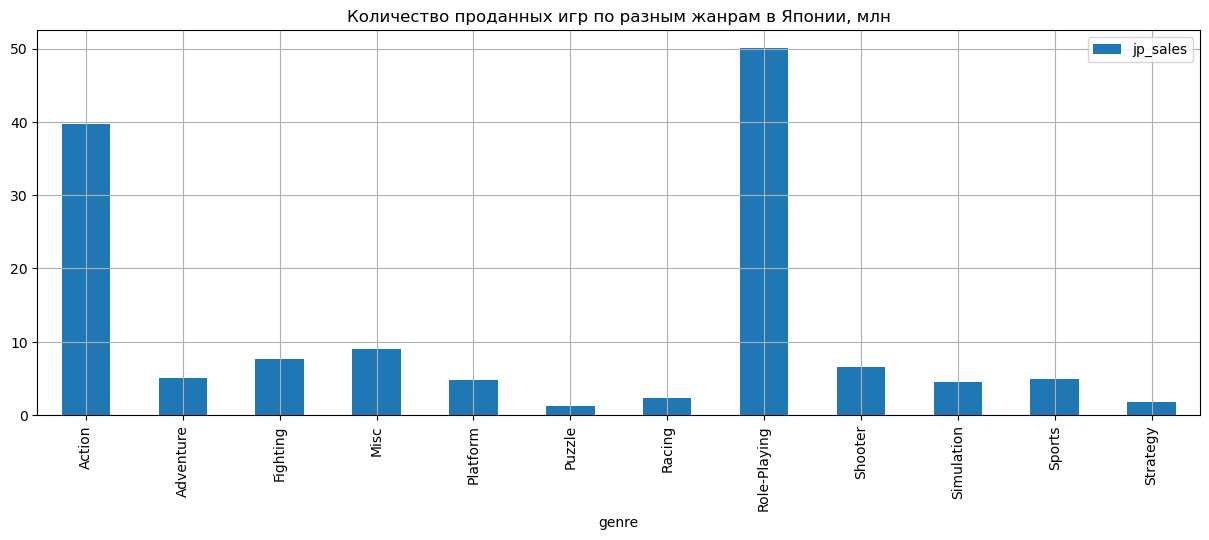

In [44]:
data_games_actual_period.pivot_table(index='genre', values='jp_sales', aggfunc='sum').plot(
    grid=True, y='jp_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр по разным жанрам в Японии, млн'
)
pass

По графикам можно сделать следующие выводы по топ-5 жанров в различных регионах:
- Северная Америка - **Action**, **Shooter**, **Sports**, **Role-Playing**, **Misc**;
- Европа - **Action**, **Shooter**, **Sports**, **Role-Playing**, **Racing**;
- Япония - **Role-Playing**, **Action**, **Misc**, **Fighting**, **Shooter**.

В указанных регионах топ-5 жанров практический одинаковый, различаются между собой на один-два жанра. В Северной Америке и Европе больше всего предпочитают **Action** и **Shooter**, а в Японии **Role-Playing** и **Action**. Популярность игр жанров **Role-Playing** в Японии связана с тем, что в таких играх больше уделяются внимание различным деталям, там можно быть много различных ответвлений в сюжете или же какие-то головомки, которые любят в Японии. Также много популярных игр такого жанра были разработаны в Японии в которые разработчики игр добавляли элементы своей культуры за счет чего игры становились популярны в Северной Америке или Европе, так как для этих регионов такие элементы в играх приносили что-то новое для игрока, и можно заметить что игры жанра **Role-Playing** входит в топ-5 в Северной Америке и Европе. Популярность жанра **Fighting** в Японии можно объяснить тем, что эта страна различных боевых искусстви и логично предположить игры с таким жанром в стране будут популярны.

В самой Европе и Северной Америке предпочитают игры жанра **Action** и **Shooter** из-за того что в этих регионах популярные различные сюжеты связанные с приключениями, здесь можно провести параллель с фильмами и мультфильмам, которые делают в этих регионах, а также популярность комиксов по которым снято уже несколько фильмов, по этим же фильмам, мультфильмам или комиксам разрабатывают игры и они чаще всего имеют жанр **Action** или **Shooter**. Также в Европе и Северной Америке популярны жанра **Sports** вероятно люди в этих регионах много внимания уделяют спорту в своей жизни и засчет этого игры с таким жанром становятся популярны.

Проверим также влияет ли рейтинг от организации ESRB, который присваевает возрастную категорию игры, на количество продаж игр.

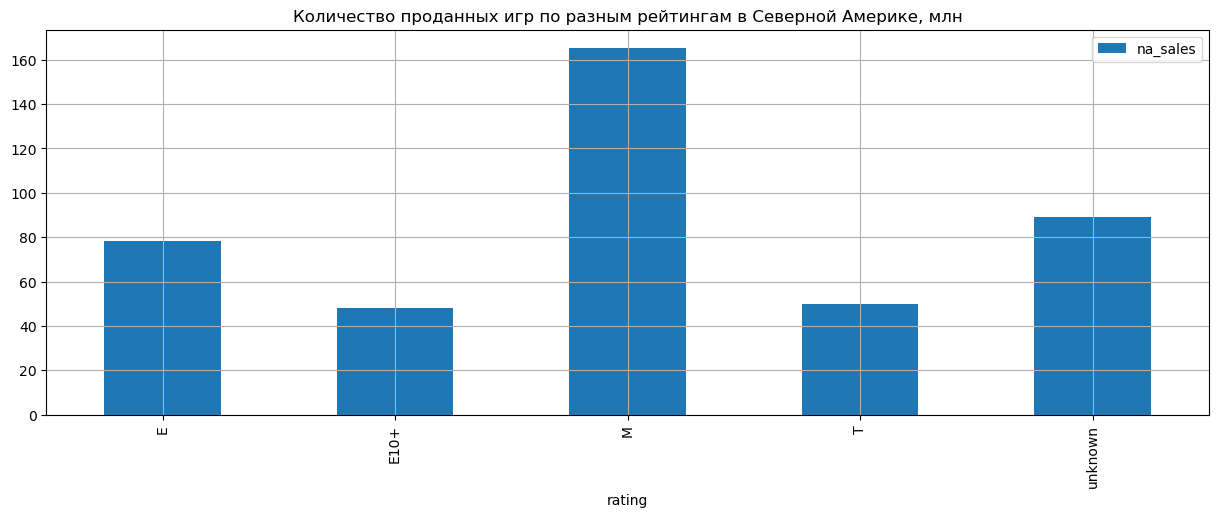

In [45]:
data_games_actual_period.pivot_table(index='rating', values='na_sales', aggfunc='sum').plot(
    grid=True, y='na_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр по разным рейтингам в Северной Америке, млн'
)
pass

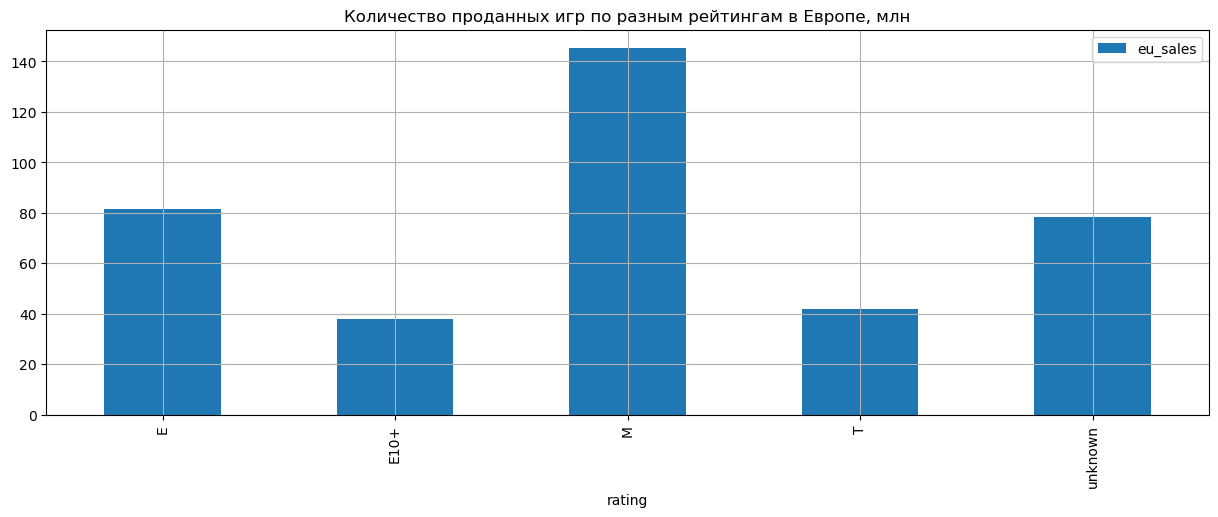

In [46]:
data_games_actual_period.pivot_table(index='rating', values='eu_sales', aggfunc='sum').plot(
    grid=True, y='eu_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр по разным рейтингам в Европе, млн'
)
pass

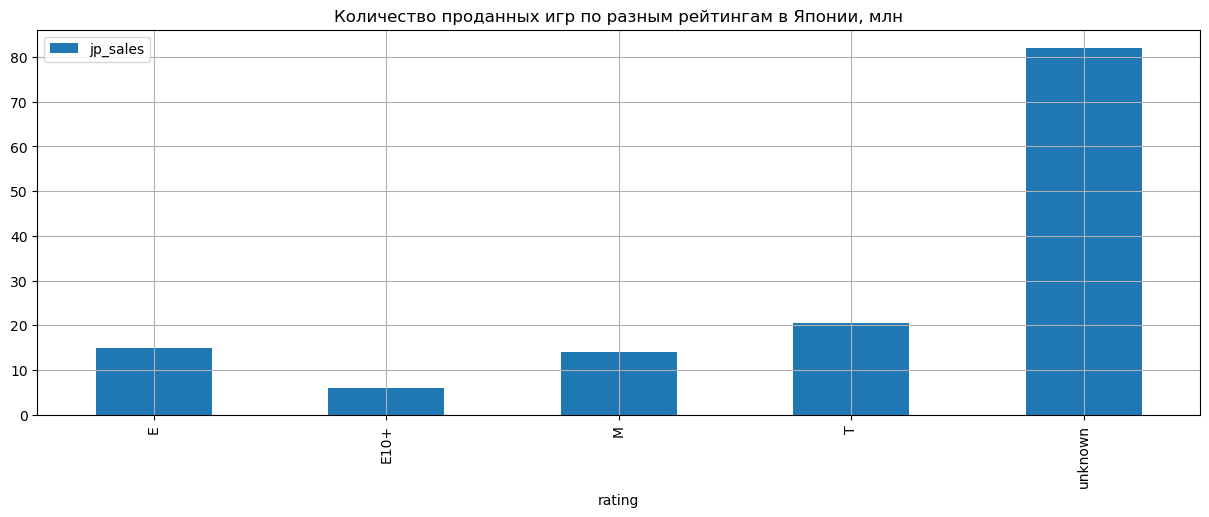

In [47]:
data_games_actual_period.pivot_table(index='rating', values='jp_sales', aggfunc='sum').plot(
    grid=True, y='jp_sales', kind='bar', figsize=(15, 5), 
    title='Количество проданных игр по разным рейтингам в Японии, млн'
)
pass

По графикам можно сделать вывод, что в Северной Америке и Европе больше всего предпочитают игры, который имеют рейтинг **M**, то есть для людей от 17 лет и с рейтингом **E** для всех возрастов и рейтинг в этих регионах влияет на продажи, так как такие игры имеют больше всего продаж. В Японии же больше всего купили игр, рейтинг по которым неизвестен или ещё не определен и здесь рейтинг не влияет на продажи.

На основании выше проведенного исследования, можно составить следующий портрет для каждого региона: 

В Северной Америке больше всего предпочитают игры жанра **Action**, **Shooter**, **Sports**, **Role-Playing**, **Misc** с рейтингом **M** (игры для людей с 17 лет) и **E**(игры для всех возрастов) на платформах **PS4**, **XOne**, **X360**, **PS3**, **3DS**.

В Европе больше всего предпочитают игры жанра **Action**, **Shooter**, **Sports**, **Role-Playing**, **Racing** с рейтингом **M** (игры для людей с 17 лет) и **E** (игры для всех возрастов) на платформах **PS4**, **PS3**, **XOne**, **X360**, **3DS**. По сравнению с Северной Америкой платформы такие же, жанры отличаются на один, вместо игр жанра **Misc** в Европе преподчитают игры жанра **Racing**.

В Японии больше всего предпочитают игры жанра **Role-Playing**, **Action**, **Misc**, **Fighting**, **Shooter** на платформах **3DS**, **PS3**, **PSV**, **PS4**, **WiiU** независимо от возрастного рейтинга игр.

### Проверка гипотез

Проверим гипотезу, что средние пользовательские рейтинги платформ **XOne** и **PC** одинаковые, сформулируем нулевую и альтернативные гипотезы, гипотезы будем формулировать с учетом того, что нам нужно проверить средние значения:

```
H_0: Средний пользовательский рейтинг на платформе "XOne" ≠ Средний пользовательский рейтинг на платформе "PC"
H_a: Средний пользовательский рейтинг на платформе "XOne" = Средний пользовательский рейтинг на платформе "PC"
```

Пороговое значение возьмем следующее - alpha = 0.05

Знак **=** и **≠** указаны в гипотезах, потому что мы проверяем равны ли средние между собой, а не то, что одно среднее больше или меньше другого. Так как мы проверяем, что средние значения одинаковые, то в качестве нулевой гипотезы указываем, что средние значения не равны между собой.

Для проверки гипотез воспользуемся методом `ttest_ind` из библиотеки `stats`, берем это метод, потому что он позволяет проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, а гипотезы у нас сформулированные как раз для проверки средних значений и выборки у нас не зависимы между собой. Для параметра `equal_var` о равенстве дисперсий выборок указываем значения **False**, так как нам неизвестно равны ли дисперсий двух выборок между собой.

In [48]:
results = st.ttest_ind(data_games_actual_period[(data_games_actual_period['platform'] == 'XOne') & 
                                                ~(data_games_actual_period['user_score'].isna())]['user_score'], 
                       data_games_actual_period[(data_games_actual_period['platform'] == 'PC') & 
                                                ~(data_games_actual_period['user_score'].isna())]['user_score'], 
                       equal_var=False)

alpha = 0.05
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Так как не получилось отвергнуть нулевую гипотезу, то средние пользовательские рейтинги платформ **XOne** и **PC** не равны между собой.

Теперь проверим гипотезу связанную с жанрами игры, определим, что средние пользовательские рейтинги жанров **Action** (англ. «действие», экшен-игры) и **Sports** (англ. «спортивные соревнования») разные, сформулируем нулевую и альтернативную гипотезы аналогично тем, что указали ранее, только вместо платформы укажем жанры игр. 

```
H_0: Средний пользовательский рейтинг жанра "Action" ≠ Средний пользовательский рейтинг жанра "Sports"
H_a: Средний пользовательский рейтинг жанра "Action" = Средний пользовательский рейтинг жанра "Sports"
```

Пороговое значение укажим такое же как в прошлый раз alpha = 0.05

Для проверки гипотез будем использовать точно такой же метод `ttest_ind` как и в прошлой проверке, по типу мы проверяем точно такую же гипотезу как и в прошлый раз, только вместо платформ жанры игр.

In [49]:
results = st.ttest_ind(data_games_actual_period[(data_games_actual_period['genre'] == 'Action') & 
                                                ~(data_games_actual_period['user_score'].isna())]['user_score'], 
                       data_games_actual_period[(data_games_actual_period['genre'] == 'Sports') & 
                                                ~(data_games_actual_period['user_score'].isna())]['user_score'], 
                       equal_var=False)

alpha = 0.05
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  6.50128644950287e-20
Отвергаем нулевую гипотезу


По полученным результаты, мы отвергаем нулевую гипотезу и принимаем гипотезу о том, что средние пользовательские рейтинги от пользователей по жанрам **Action** и **Sports** равны между собой.

### Общий вывод

В рамках анализа нам нужно было выявить определяющие успешность игры закономерности, чтобы сделать ставку на популярный продукт и спланировать рекламную компанию на следующий год. Проведя анализ удалось выяснить в разных регионах топ-5 популярных платформ и жанров игры, выглядят они следующим образом по платформам:

- Северная Америка - **PS4**, **XOne**, **X360**, **PS3**, **3DS**;
- Европа - **PS4**, **PS3**, **XOne**, **X360**, **3DS**;
- Япония - **3DS**, **PS3**, **PSV**, **PS4**, **WiiU**.

И по жанрам игр:

- Северная Америка - **Action**, **Shooter**, **Sports**, **Role-Playing**, **Misc**;
- Европа - **Action**, **Shooter**, **Sports**, **Role-Playing**, **Racing**;
- Япония - **Role-Playing**, **Action**, **Misc**, **Fighting**, **Shooter**.

По количеству проданных игр лидирует платформа **PS4**, за два года подряд у этой платформы было продано от 100 млн копий игр, однако с помощью графиков удалось выяснить, что платформа **PS4** не сильно популярна в Японии и там предпочитают платформу **3DS**, что позволяет платформе **3DS** продавать большое количество игр, что также нам удалось подтвердить с помощью графиков. С помощью графиков по возрастному рейтингу ESRB удалось выяснить, что в Северной Америке и Европе предпочитают игры с рейтингом **M** (игры для людей с 17 лет) и **E**(игры для всех возрастов), а в Японии возрастной рейтинг не влияет на количество продаж.

Также мы определили зависимость количество проданных копий игр от оценки критиков с помощью диаграммы рассеяния, чем лучше оценка от критиков, тем больше проданных копий игры. А вот зависимости количества проданных игр от оценки пользователей нет, видимо люди чаще больше доверяют в плане оценок знающим людям, чем другие игрокам.

С помощью проверки гипотез нам удалось определить, что средние пользовательские рейтинги равны в жанрах **Action** и **Sports**, а вот по платформа наоброт - средние пользовательские рейтинги не равны на платформах **XOne** и **PC**. Данная информацию можно использовать при планировании рекламной кампании, например в регионах где популярен жанр **Action** можно сделать и реклманую кампанию по жанру **Sports**.

Также мы определили, что по количеству проданных копий игр выделяются следующие жанры - **Shooter**, **Sports**, **Platform**, **Fighting**.

На основании вышеизложенного рекламную кампанию на следующий год нужно планировать в зависимости от региона, в Северной Америке и в Европе следует делать упор рекламной кампании на платформу **PS4** и игры жанра **Shooter** и **Sports**. Также, чтобы увеличить число продаж стоит добавить в рекламную кампанию информацию о возрастном рейтинге игр, в этих регионах предпочитают игры **M** (игры для людей с 17 лет) и **E**(игры для всех возрастов).

В Японии же нужно делать упор рекламной кампании на платформу **3DS** и жанры игр **Fighting** и **Shooter**, так как эта самая популярная платформа в Японии, а указанные жанры входят в топ-5 в этой стране и приносят больше всего прибыли по сравнению с другими жанрами, которые популярны в этой стране.

И также для всех регионов нужно добавлять в рекламную кампанию информацию о том, что ранее игра на эту платформу или этого жанра была высоко оценена критиками, что поможет увеличить количество продаж, так как между оценкой критиков и количеством продаж есть зависимость.